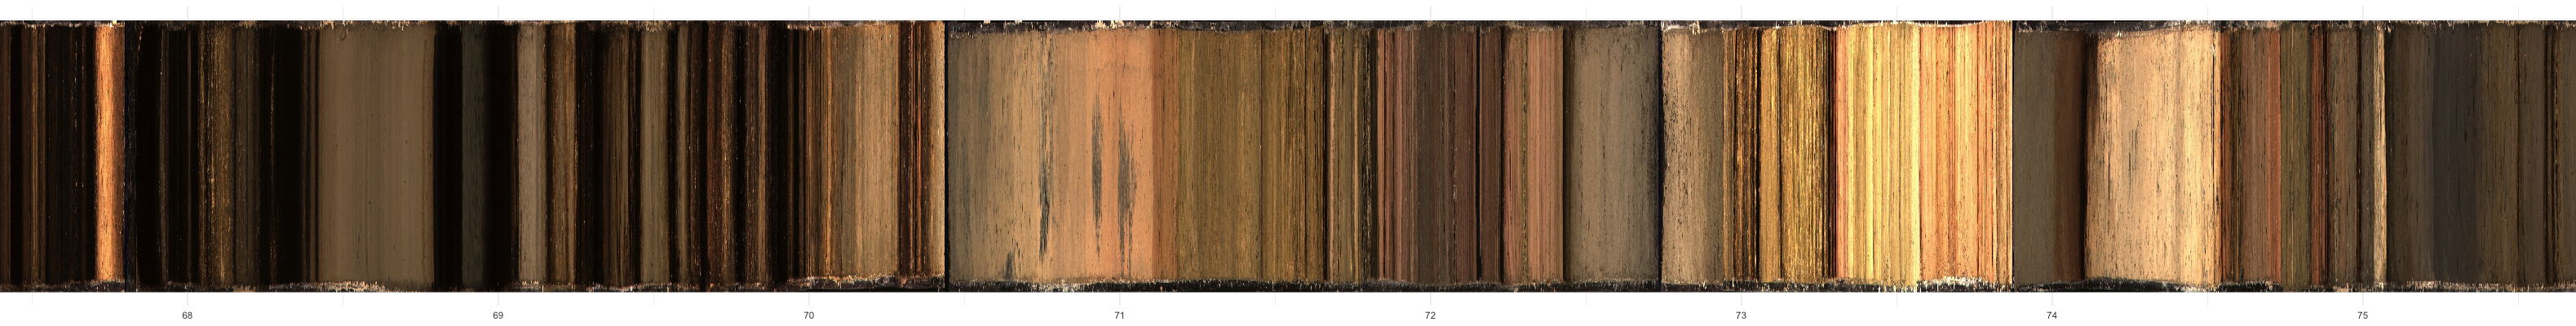

# Paleoclimate analysis of sediment cores from Lake Junín, Peru

This notebook details some of the analytical workflows and data visualizations used in my research into past climate change in tropical South America. The following geochemical data sets were generated for sediment cores from Lake Junín: x-ray fluoresence (XRF), stable oxygen and carbon isotopes, total organic carbon, calcium carbonate, sediment bulk density, and clastic flux. 

The sediment cores analyzed here span the past 50 ka (kiloannum, or 50,000 years) which is the window during which radiocarbon dating can be used to determine the age of geologic records. Peer-reviewed publications related to this research are available here (open access):

> <b>Woods et al. 2020</b> (https://www.nature.com/articles/s41467-020-19000-8)
<br>
> <b>Rodbell et al. 2022</b> (https://www.nature.com/articles/s41586-022-04873-0)
   

# Table of Contents

#### 1. [Load libraries and data](#section_1)
#### 2. [Data cleaning](#section_2)
> ##### [XRF](#section_2_1)
> ##### [Clastic Flux](#section_2_2)
> ##### [Coulometry](#section_2_3)
> ##### [Data Verification](#section_2_4)
> > ##### [Carbon](#section_2_4_1)
> > ##### [Isotopes](#section_2_4_2)
> > ##### [Density](#section_2_4_3)
#### 3. [Exploratory data analysis](#section_3)
> ##### [Stable isotopes during the Holocene](#section_3_1)
> ##### [Mineral content during the Glacial Period](#section_3_2)
> ##### [High resolution elemental proxies](#section_3_3)
#### 4. [Visualization and interpretation](#section_4)


<a name="section_1"></a>
# 1. Load libraries and data

In [298]:
library(tidyverse)
library(readxl)
library(writexl)
library(gridExtra)
library(cowplot)
library(GGally)
library(correlation)
library(DT)
library(ggpubr)

# read in excel files and convert to data frames
xrf_upper <- data.frame(read_excel('~/JuninJupyterNotebook/XRF_transect.xlsx'))
xrf_lower <- data.frame(read_xlsx('~/JuninJupyterNotebook/XRF_17.6m.xlsx'))
flux_original <- data.frame(read_xlsx('~/JuninJupyterNotebook/flux.xlsx'))
insolation <- data.frame(read_xlsx('~/JuninJupyterNotebook/insolation.xlsx'))
coulometry_original <- data.frame(suppressWarnings(suppressMessages(
    read_xlsx('~/JuninJupyterNotebook/Coulometry_BulkDensity_d13C_d18O_190612.xlsx'))))

<a name="section_2"></a>
# 2.  Data cleaning

<b>Sources of data:</b>
Modern instrumental records that are used to track climate change are generally limited to the last few hundred years. Paleoclimate studies help us to understand the magnitude and rate of change on longer timescales, based on geologic archives such as ice cores, tree rings, cave deposits, and ocean and lake sediments. These archives preserve geochemical indicators known as "proxies" that change in response to climate and environmental conditions. The research here focuses on the following proxies measured on sediment cores from Lake Junín:

<u>Proxies for glacial erosion and rainfall amount:</u> 
- counts of elements such as titanium, silicon, aluminum, potassium
- clastic flux
- sediment density

<u>Proxies for rainfall amount and lake level: </u>
- organic carbon content
- oxygen and carbon isotopes

<b>Data cleaning procedures:</b>
These proxies were measured over the course of several years at different laboratories, using a variety of instruments and data collection practices. As such, there are often inconsistencies in spreadsheet format, naming conventions, and sample spacing. Missing values and erroneous data points are also common. The cleaning processes detailed below start with the raw files and address several such issues.


<a name="section_2_1"></a>
## X-Ray Fluorescence (XRF)
XRF instruments use an optical core scanner to collect counts of most elements from aluminum (atomic #13) to uranium (#92). Elements of interest in this study are aluminum, silicon, titanium, and potassium (Al, Si, Ti, K). Two sets of XRF data were generated that need to be tidied and merged.

In [299]:
# rename and select only necessary columns from each data set
xrf_upper <- xrf_upper |> 
  rename(age = bacon22,
         age_min = bacon22min95,
         age_max = bacon22max95,
         depth_m = compDepthCol,
         aluminum = Al.corrected,
         silicon = Si.corrected,
         titanium = Ti.corrected,
         potassium = K.corrected,
         section_depth_cm = Section.Depth..cm.) |>
  select(SectionID, section_depth_cm, age, age_min, age_max, depth_m, aluminum, silicon, titanium, potassium)
  
xrf_lower <- xrf_lower |> 
  rename(age = bacon22,
         age_min = bacon22min95,
         age_max = bacon22max95,
         depth_m = compDepthCol,
         aluminum = Al,
         silicon = Si,
         titanium = Ti,
         potassium = K,
         section_depth_cm = Section.Depth.cm.) |>
  select(SectionID, section_depth_cm, age, age_min, age_max, depth_m, aluminum, silicon, titanium, potassium)

# combine the two data sets
xrf_full <- rbind(xrf_upper, xrf_lower)
glimpse(xrf_full)

Rows: 4,765
Columns: 10
$ SectionID        <chr> "PLJL-JUN15-6A-1L-1", "PLJL-JUN15-6A-1L-1", "PLJL-JUN…
$ section_depth_cm <dbl> 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0…
$ age              <dbl> 236.0, 245.5, 255.0, 264.0, 273.0, 282.5, 292.0, 301.…
$ age_min          <dbl> 66.0, 81.0, 96.0, 106.5, 117.0, 122.5, 128.0, 132.5, …
$ age_max          <dbl> 388.0, 391.5, 395.0, 399.0, 403.0, 407.5, 412.0, 418.…
$ depth_m          <dbl> 0.150, 0.155, 0.160, 0.165, 0.170, 0.175, 0.180, 0.18…
$ aluminum         <dbl> NA, 215.9027, 140.2870, 169.1403, 170.1353, 171.1302,…
$ silicon          <dbl> NA, 487.0661, 445.9882, 359.6409, 334.4912, 442.6349,…
$ titanium         <dbl> NA, 1166.9155, 658.6660, 781.3742, 778.9992, 938.9157…
$ potassium        <dbl> NA, 878.814566, 607.107677, 473.269863, 316.050743, 1…


In [300]:
# Count and remove unnecessary NAs
colSums(is.na(xrf_full)) 
xrf_full <- xrf_full |> drop_na()

SectionID section_depth_cm              age          age_min 
               0                0             1261             1261 
         age_max          depth_m         aluminum          silicon 
            1261             1261                1                1 
        titanium        potassium 
               1                1

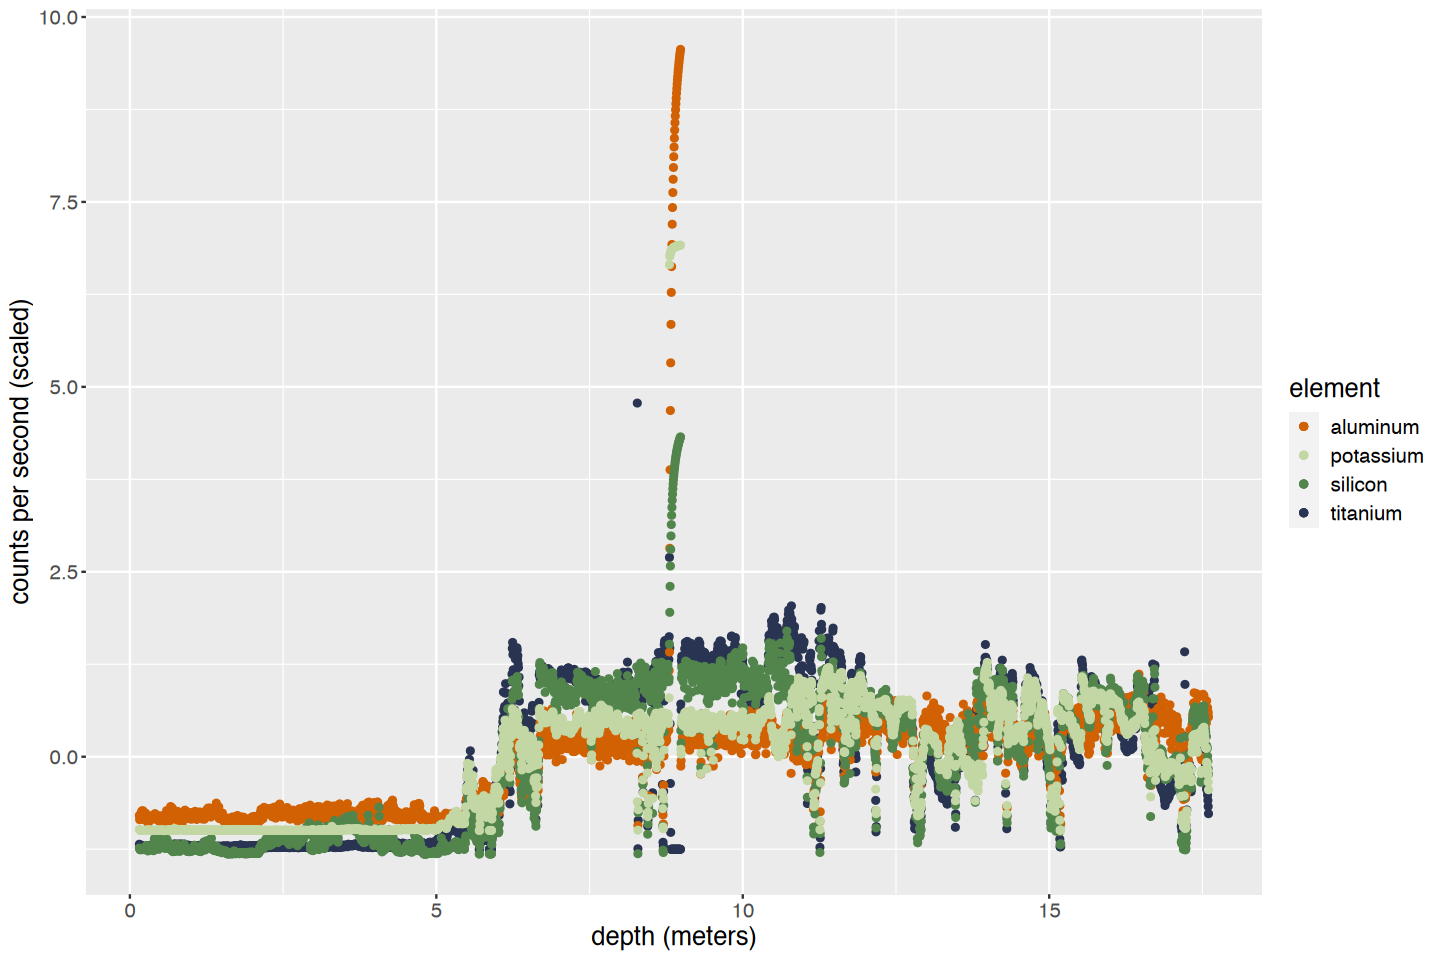

In [301]:
# Scatter plot to check for outliers; variables are scaled so they can be viewed on the same plot

options(repr.plot.width = 12, repr.plot.height = 8)
xrf_scatter_plot <- ggplot(
  data = xrf_full,
  mapping = aes(x = depth_m)) +
  geom_point(mapping = aes(y = scale(titanium), color = 'titanium')) +
  geom_point(mapping = aes(y = scale(aluminum), color = 'aluminum')) +
  geom_point(mapping = aes(y = scale(silicon), color = 'silicon')) +
  geom_point(mapping = aes(y = scale(potassium), color = 'potassium')) +
  scale_colour_manual(name="element",
                      values=c("#D16103", "#C3D7A4", "#52854C", "#293352")) + 
  labs(y = "counts per second (scaled)") +
  labs(x = "depth (meters)") +
  theme(text=element_text(size=15))

suppressWarnings(print(xrf_scatter_plot))

Since these outliers are present for all elements in the same depth range, we can assume they arose from instrument error and can be removed. Same goes for any rows where <b>all four</b> elements have counts of zero:

In [302]:
# Remove outliers - filter rows with Al and Ti values below thresholds
xrf_filtered <- xrf_full |> filter(aluminum < 2500 & titanium < 100000)

In [303]:
# Return a subset of data where counts for all elements are zero
zeroes <- xrf_filtered |> filter(titanium == 0 & aluminum == 0 & silicon == 0 & potassium == 0) |> 
  select(!c(age_min, age_max)) 

# Remove those rows from the XRF data frame
xrf <- anti_join(xrf_filtered, zeroes) 

Joining with `by = join_by(SectionID, section_depth_cm, age, depth_m, aluminum,
silicon, titanium, potassium)`


#### A final look at the cleaned data set:

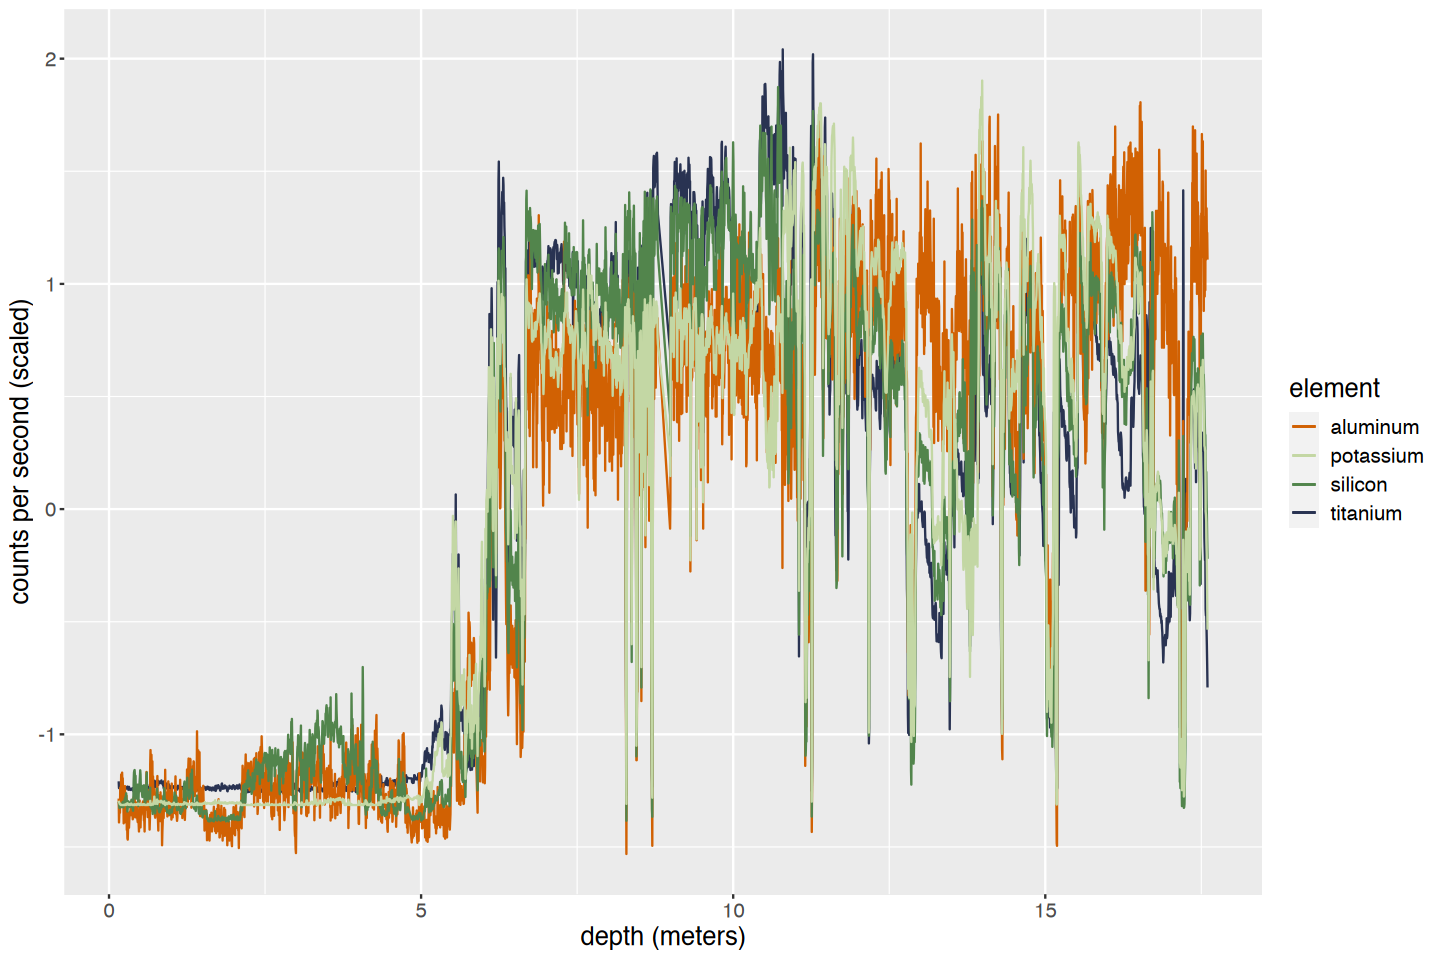

In [304]:
ggplot(
  data = xrf,
  mapping = aes(x = depth_m)) +
  geom_line(mapping = aes(y = scale(titanium), color = 'titanium')) +
  geom_line(mapping = aes(y = scale(aluminum), color = 'aluminum')) +
  geom_line(mapping = aes(y = scale(silicon), color = 'silicon')) +
  geom_line(mapping = aes(y = scale(potassium), color = 'potassium')) +
  scale_colour_manual(name="element",
                      values=c("#D16103", "#C3D7A4", "#52854C", "#293352")) + 
  labs(y = "counts per second (scaled)") +
  labs(x = "depth (meters)") +
  theme(text=element_text(size=15))

<a name="section_2_2"></a>
## Data cleaning - Clastic Flux

Clastic flux is a measure of rock fragments ("clasts") derived mainly from quartz particles and clay minerals via erosion of bedrock. Flux refers to the transport of these minerals that are washed into the lake, and is measured in grams/cm<sup>2</sup>/year.


In [305]:
flux <- flux_original |> 
  rename(clastic_flux_gcm2yr = siliclastic.flux.g.cm2.yr,
         depth_m = compDepthCol,
         age = bacon22.weighted.mean.age) |> 
  select(age, depth_m, clastic_flux_gcm2yr)

In [306]:
colSums(is.na(flux))

age             depth_m clastic_flux_gcm2yr 
                  0                   0                   0

In [307]:
glimpse(flux)

Rows: 759
Columns: 3
$ age                 <dbl> 282.5, 311.0, 335.5, 368.0, 400.0, 429.0, 459.5, 4…
$ depth_m             <dbl> 0.175, 0.190, 0.205, 0.230, 0.255, 0.280, 0.305, 0…
$ clastic_flux_gcm2yr <dbl> 0.003531851, 0.003743486, 0.003491321, 0.003989315…


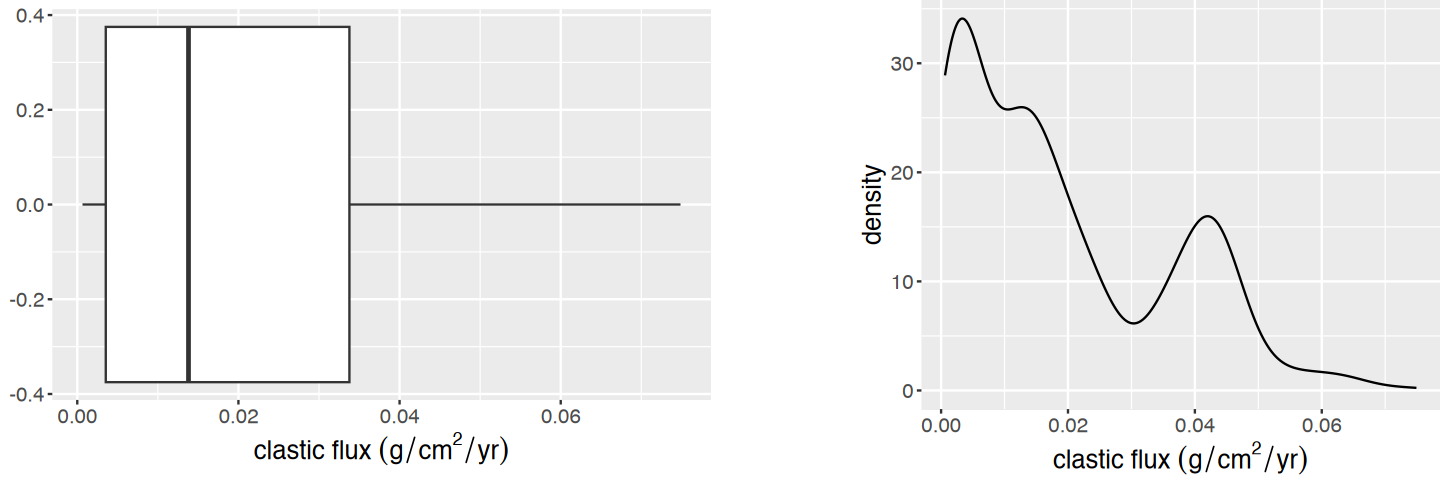

In [308]:
# Box-and-whisker and density plots to check for outliers and skew
box_plot <- ggplot(
  data = flux,
  mapping = aes(x = clastic_flux_gcm2yr)) +
  geom_boxplot(outlier.colour = 'red') +
  labs(x=bquote('clastic flux '(g/cm^2/yr))) +
  theme(text=element_text(size=15))

density_plot <- ggplot(
  data = flux,
  mapping = aes(x = clastic_flux_gcm2yr)) +
  geom_density() +
  labs(x=bquote('clastic flux '(g/cm^2/yr))) +
  theme(plot.margin=margin(l=3, unit = 'cm'),
       text=element_text(size=15))

options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(box_plot, density_plot, ncol = 2, nrow = 1)


<br>

The box plot indicates there are no outliers, but the data is right-skewed and shows two modes - we will address this in a subsequent section.

<a name="section_2_3"></a>
## Data cleaning - Coulometry

Carbon coulometry is a lab method used to quantify total organic carbon (TOC) and calcium carbonate (CaCO<sub>3</sub>) content of geologic materials; the carbonate fraction is further used to generate carbon and oxygen isotope measurements.

The original file is messy - it comprises two sets of data that were generated with different collection techniques and naming conventions, there are many missing values, and several columns with key identifying information are not filled in. 

Ultimately, this file needs to be processed by an external script which does the following:
1) reads each row to find the sediment core name and sample depth,
2) matches that info to a table/key for calculating total depth below Earth's surface, and
3) matches the total depths to radiometric age estimates from a user-generated model.

The following columns need to be populated: "Section" and "Section Depth(cm)" (required), and "SiteHole" and "Core" (required if available). 

In [309]:
# Get rid of unnecessary columns and rename them
coulometry_trimmed <- coulometry_original |> 
  select(!c(Project, Location...2, Location...3, Year, Volume, 
            Requested.Section.Depth.Top..cm., 
            Requested.Section.Depth.Bottom..cm.,
            ...28,
            Total.Inorganic.Carbon..wt.., 
            Total.Carbon..wt.., 
            Wet.bulk..density..g.cc., 
            Dry.wt...g.)) |> 
  rename(SiteHole = X1a.SiteHole,
         'Section Depth(cm)' = Sec.Depth.Midpoint.Sampled..cm.,
         section_depth_top_cm = Sec.Depth.T.Sampled,
         section_depth_bottom_cm = Sec.Depth.B.Sampled,
         splice_type = Splice.Type,
         CCLF_PLJ_depth_m = CCLF.PLJ.Depth..meters.,
         section_ID = Section.ID,
         CaCO3_wt_pct = CaCO3..wt..,
         TOC_wt_pct = Total.Organic.Carbon..wt..,
         dry_bulk_density_gcc = Dry.bulk.density..g.cc.,
         Isotope_notes_duplicates = Isotope.Notes.or.duplicates)

In [310]:
# key identifying info is missing for the first 681 rows
sum(is.na(coulometry_trimmed$Section))

# so split the data frame and work on the upper subset
coulom_subset1 <- coulometry_trimmed[1:681,]
coulom_subset2 <- coulometry_trimmed[682:4565,]

[1] 681

In [311]:
# The "Name" column contains all the info needed, but it's a string with inconsistent formatting:
coulom_subset1$Name |> head(5)

[1] "Junín C-15 D-1 0-1 cm" "Junín C-15 D-1 1-2 cm" "Junin C15 D1 2.5"     
[4] "Junín C-15 D-1 3-4 cm" "Junin C15 D1 4"


<u>Note:</u> 
In the sample names above, the core section may or may not contain hyphens:  'Junín <b>C-15 D-1</b> 1-2 cm'  or 'Junin <b>C15 D1</b> 2.5'
<br>
And the section depth may or may not contain a number range followed by "cm":  'Junín C-15 D-1 <b>1-2 cm</b>'  or 'Junin C15 D1 <b>2.5</b>'

We will use <b>regular expressions</b> to parse the "Name" column and fill in "Section" and "Section Depth(cm)".

In [312]:
# Preserve a duplicate of the Name column
coulom_subset1$NameBackup <- coulom_subset1$Name

coulom_subset1 |> head(5)

SiteHole      Core Section section_ID Section Depth(cm) CCLF_PLJ_depth_m
1 transect core NA   NA      NA          NA               0.155           
2 transect core NA   NA      NA          NA               0.165           
3 transect core NA   NA      NA         2.5               0.175           
4 transect core NA   NA      NA          NA               0.185           
5 transect core NA   NA      NA         4.0               0.190           
  splice_type section_depth_top_cm section_depth_bottom_cm
1 NA          NA                   NA                     
2 NA          NA                   NA                     
3 NA          NA                   NA                     
4 NA          NA                   NA                     
5 NA          NA                   NA                     
  Name                  CaCO3_wt_pct TOC_wt_pct dry_bulk_density_gcc d13C 
1 Junín C-15 D-1 0-1 cm       NA           NA       NA               10.15
2 Junín C-15 D-1 1-2 cm       NA           NA       NA               10.14
3 Junin C15 D1 2.5      48.31024     17.08826   0.1322               10.36
4 Junín C-15 D-1 3-4 cm       NA           NA       NA               10.37
5 Junin C15 D1 4        54.81358     13.96097   0.1985                  NA
  d18O  Isotope_notes_duplicates NameBackup           
1 -6.86 NA                       Junín C-15 D-1 0-1 cm
2 -6.91 NA                       Junín C-15 D-1 1-2 cm
3 -6.90 NA                       Junin C15 D1 2.5     
4 -6.57 NA                       Junín C-15 D-1 3-4 cm
5    NA NA                       Junin C15 D1 4

In [313]:
# Split the contents of "Name" into several new columns, discard spaces and hyphens: 

coulom_subset1 <- coulom_subset1 |>
  separate_wider_regex(cols = Name,
                       patterns = c(lake = "\\w+",
                                    " ",
                                    core = "\\w",
                                    "-*",
                                    year = "\\d{2}",
                                    " ",
                                    drive = "D+",
                                    "-*",
                                    drive_num = "\\d+-*\\d*",
                                    " ",
                                    the_rest = ".*"))

coulom_subset1$drive_num <- gsub("-", "", coulom_subset1$drive_num)
coulom_subset1$SiteHole <- gsub("transect core", NA, coulom_subset1$SiteHole)

In [314]:
coulom_subset1[,10:15] |> head(5)

lake  core year drive drive_num the_rest
1 Junín C    15   D     1         0-1 cm  
2 Junín C    15   D     1         1-2 cm  
3 Junin C    15   D     1         2.5     
4 Junín C    15   D     1         3-4 cm  
5 Junin C    15   D     1         4

In [315]:
# Splitting the column "the_rest" requires additional regex functions that deal with NA values:
coulom_subset1$midpoint <- str_extract(coulom_subset1$the_rest, "\\d*.*\\d+$")
coulom_subset1$range_cm <- str_extract(coulom_subset1$the_rest, "\\d+-\\d+")

coulom_subset1[,22:24] |> head(5)

NameBackup            midpoint range_cm
1 Junín C-15 D-1 0-1 cm NA       0-1     
2 Junín C-15 D-1 1-2 cm NA       1-2     
3 Junin C15 D1 2.5      2.5      NA      
4 Junín C-15 D-1 3-4 cm NA       3-4     
5 Junin C15 D1 4        4        NA

In [316]:
# split "range_cm" into two columns then take the average to populate missing values in the "midpoint" column
coulom_subset1 <- coulom_subset1 |> 
  separate(range_cm, c('start_cm', 'end_cm'), sep = "-") |> 
  relocate(midpoint, start_cm, end_cm, .after = drive_num) |> 
  mutate_at(c('midpoint', 'start_cm', 'end_cm'), as.numeric) |> 
  mutate(midpoint = if_else(is.na(midpoint), (start_cm + end_cm) / 2, midpoint)) |> 
  rename(Name = NameBackup) |> 
  relocate(Name, .after = section_depth_bottom_cm)

In [317]:
coulom_subset1[,10:19] |> head(5)

Name                  lake  core year drive drive_num midpoint start_cm
1 Junín C-15 D-1 0-1 cm Junín C    15   D     1         0.5       0      
2 Junín C-15 D-1 1-2 cm Junín C    15   D     1         1.5       1      
3 Junin C15 D1 2.5      Junin C    15   D     1         2.5      NA      
4 Junín C-15 D-1 3-4 cm Junín C    15   D     1         3.5       3      
5 Junin C15 D1 4        Junin C    15   D     1         4.0      NA      
  end_cm the_rest
1  1     0-1 cm  
2  2     1-2 cm  
3 NA     2.5     
4  4     3-4 cm  
5 NA     4

In [318]:
# Populate and rearrange the columms, concatenate the cleaned data frames
coulom_subset1 <- coulom_subset1 |> 
  unite(Section, c(core, year, drive, drive_num), sep = "", remove = TRUE) |> 
  relocate(Section, .after = Core) |> 
  mutate(section_depth_top_cm = if_else(is.na(section_depth_top_cm), start_cm, NA)) |> 
  mutate(section_depth_bottom_cm = if_else(is.na(section_depth_bottom_cm), end_cm, NA)) |> 
  mutate(`Section Depth(cm)` = if_else(is.na(`Section Depth(cm)`), midpoint, `Section Depth(cm)`)) |> 
  select(-c(lake, midpoint, start_cm, end_cm, the_rest))

coulometry_cleaned <- rbind(coulom_subset1, coulom_subset2)

coulometry_cleaned |> head(5)

SiteHole Core Section section_ID Section Depth(cm) CCLF_PLJ_depth_m
1 NA       NA   C15D1   NA         0.5               0.155           
2 NA       NA   C15D1   NA         1.5               0.165           
3 NA       NA   C15D1   NA         2.5               0.175           
4 NA       NA   C15D1   NA         3.5               0.185           
5 NA       NA   C15D1   NA         4.0               0.190           
  splice_type section_depth_top_cm section_depth_bottom_cm
1 NA           0                    1                     
2 NA           1                    2                     
3 NA          NA                   NA                     
4 NA           3                    4                     
5 NA          NA                   NA                     
  Name                  CaCO3_wt_pct TOC_wt_pct dry_bulk_density_gcc d13C 
1 Junín C-15 D-1 0-1 cm       NA           NA       NA               10.15
2 Junín C-15 D-1 1-2 cm       NA           NA       NA               10.14
3 Junin C15 D1 2.5      48.31024     17.08826   0.1322               10.36
4 Junín C-15 D-1 3-4 cm       NA           NA       NA               10.37
5 Junin C15 D1 4        54.81358     13.96097   0.1985                  NA
  d18O  Isotope_notes_duplicates
1 -6.86 NA                      
2 -6.91 NA                      
3 -6.90 NA                      
4 -6.57 NA                      
5    NA NA

In [319]:
# The data is then exported and processed by R scripts that read the sample info and match it to an age-depth model.
# This step (not shown here) reduces the number of rows and adds columns for depth and age. The resulting data frame:
coulometry_final <- data.frame(read_xlsx('~/JuninJupyterNotebook/coulometry_final.xlsx'))

<a name="section_2_4"></a>
## Data verification
Split the coulometry data into individual data frames by sample type and check for spread and outliers.


<a name="section_2_4_1"></a>
### Carbon

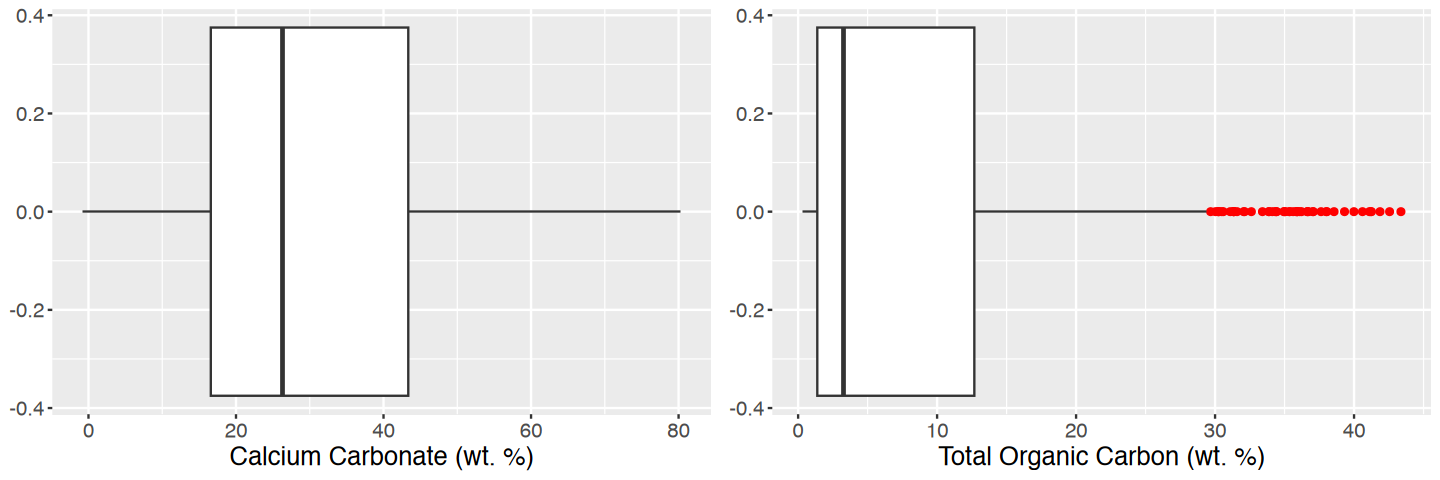

In [321]:
# Create data frame with CaCO3 and TOC
carbon <- coulometry_final |> 
  select(c(1:4, 14:15, 18)) |> 
  drop_na()

# Check for outliers with box plots 
carbon1 <- ggplot(
  data = carbon,
  mapping = aes(x = CaCO3_wt_pct)) +
  geom_boxplot(outlier.colour = 'red') + 
  labs(x = 'Calcium Carbonate (wt. %)') +
  theme(text=element_text(size=15))

carbon2 <- ggplot(
  data = carbon,
  mapping = aes(x = TOC_wt_pct)) +
  geom_boxplot(outlier.colour = 'red') +
  labs(x = 'Total Organic Carbon (wt. %)') +
  theme(text=element_text(size=15))

options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(carbon1, carbon2, ncol = 2, nrow = 1)


<br>
Both data sets are right-skewed, and the box plot indicates a large number of outliers for TOC - however, these samples are actually sedimentary peat layers, which are naturally high in organic carbon and an important piece of the story in understanding the climate and lake level in the region.
<br>
<br>
Line plots better show these high-TOC layers, which are inversely related to the amount of calcium carbonate in the sediment:
<br>
<br>

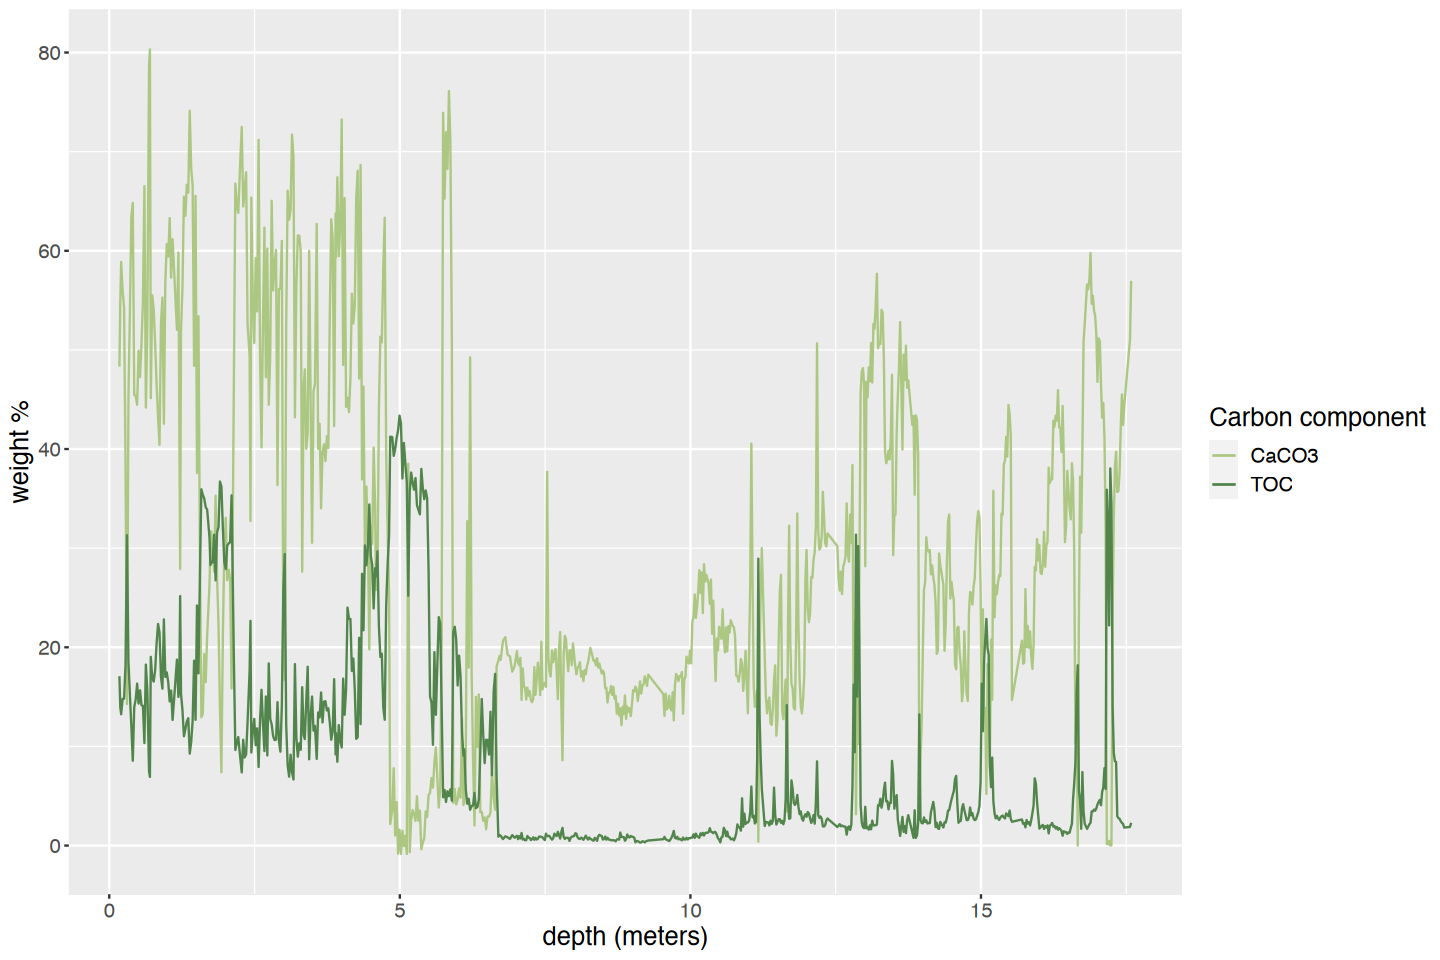

In [322]:
options(repr.plot.width = 12, repr.plot.height = 8)

ggplot(
  data = carbon,
  mapping = aes(x = depth_m)) +
  geom_line(mapping = aes(y = CaCO3_wt_pct, color = 'CaCO3')) +
  geom_line(mapping = aes(y = TOC_wt_pct, color = 'TOC')) +
  scale_colour_manual(name="Carbon component",
                    values=c("#acc781", "#52854C")) +
  labs(y = "weight %") +
  labs(x = "depth (meters)") +
  theme(text=element_text(size=15))

<a name="section_2_4_2"></a>
### Isotopes

Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


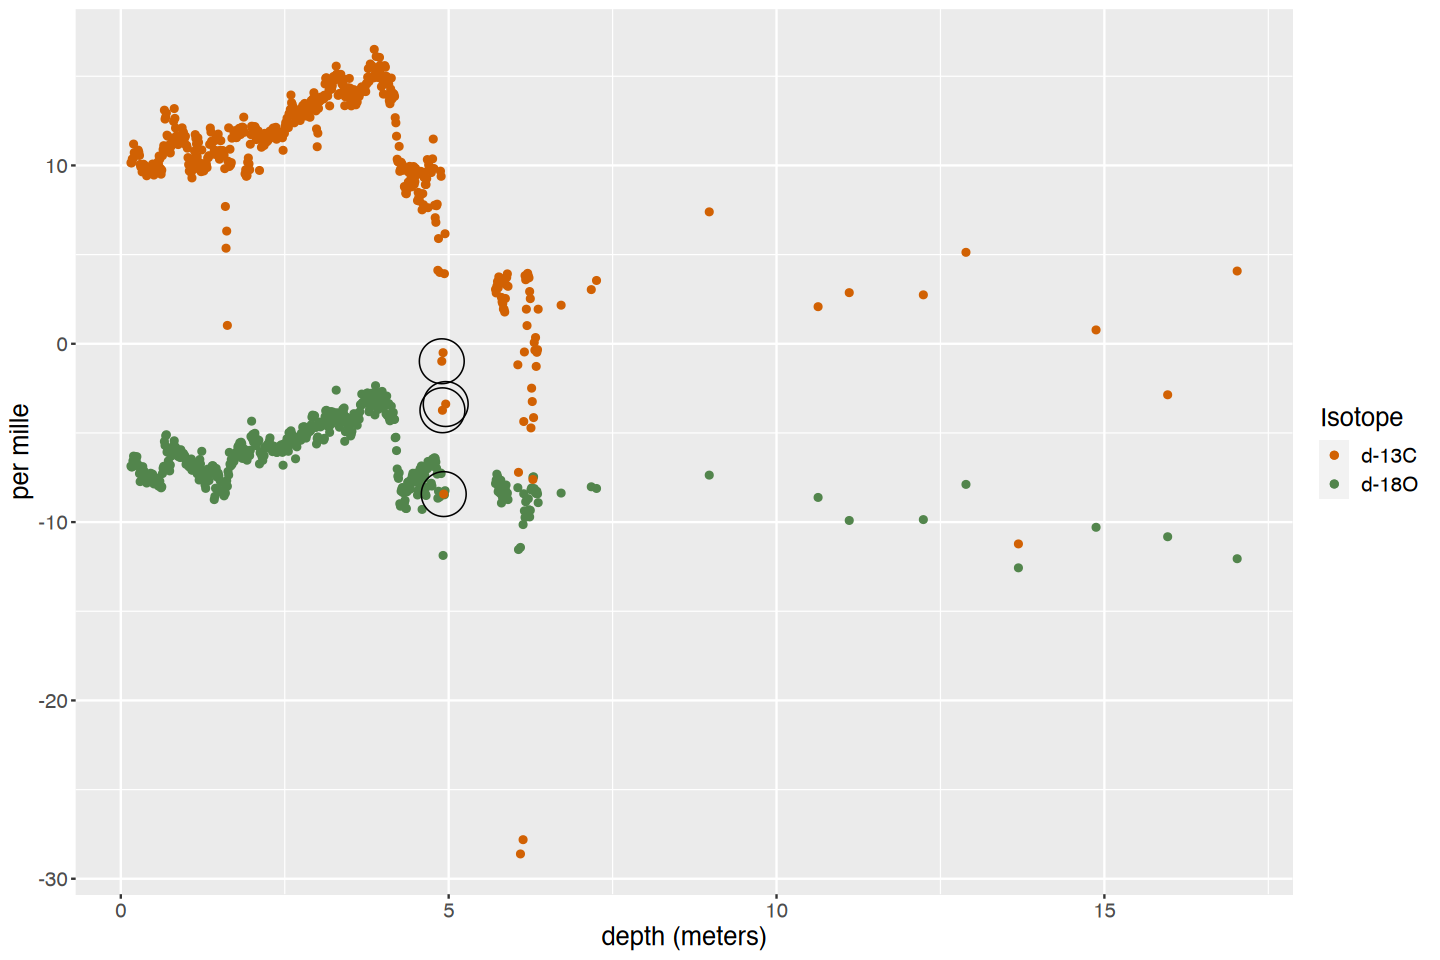

In [323]:
# Create data frame for carbon and oxygen isotopes
isotopes <- coulometry_final |> 
  select(c(1:4, d18O, d13C)) |> 
  filter(!is.na(d18O) | !is.na(d13C))

# Get rows where one column is NA and the other is not
isotopes_isolate_NA <- isotopes |> filter(is.na(d18O) | is.na(d13C))

# Plot to check if those are bad data points
options(repr.plot.width = 12, repr.plot.height = 8)             
ggplot() +
  geom_point(aes(x = isotopes$depth_m, y = isotopes$d18O, color = "d-18O")) +
  geom_point(aes(x = isotopes$depth_m, y = isotopes$d13C, color = "d-13C")) +
  geom_point(aes(x = isotopes_isolate_NA$depth_m, y = isotopes_isolate_NA$d13C), size = 12, shape = 1) + 
  scale_colour_manual(name="Isotope",
                      values=c("#D16103", "#52854C")) +
  labs(y = "per mille") +
  labs(x = "depth (meters)") +
  theme(text=element_text(size=15))

There are 4 rows where d-13C values do not have corresponding d-18O values (circled in black); this can indicate bad instrument readings, but these samples are not otherwise unusual so we'll keep them. 

Next, check for outliers using boxplots:

Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”


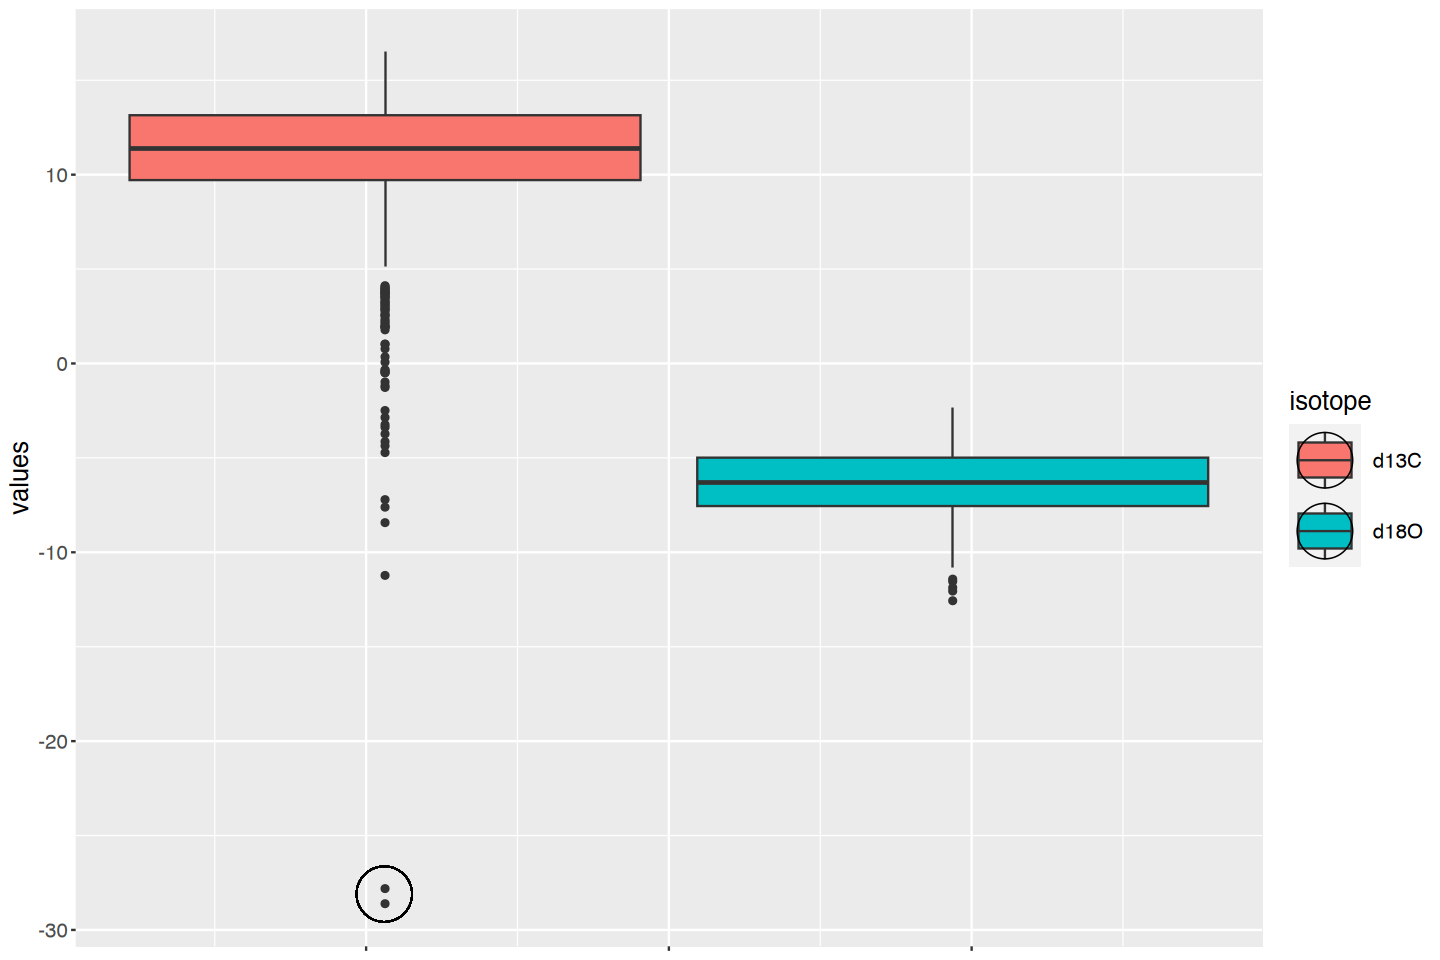

In [324]:
# pivot the data frame so we can show both isotopes in a single plot
isotopes_longer <- isotopes |> select(d18O, d13C) |> 
  pivot_longer(d18O:d13C, names_to = 'isotope', values_to = 'values')

isotopes_longer |> ggplot(
  aes(y=values, fill = isotope)) +
  geom_boxplot()  +
  geom_point(aes(x = -0.188, y = -28.1), size = 15, shape = 1) +
  theme(text=element_text(size=15),
       axis.title.x=element_blank(),
       axis.text.x=element_blank())


<br>
The box plots suggest both data sets contain outliers; however, most of these values are within the expected natural ranges for lake sediments.  The exception is d-13C values between -25 to -30 per mil (circled in black), which are not observed on earth and should be removed from the final data frame.

In [325]:
# Remove those extreme outliers
isotopes <- isotopes |> mutate(d13C = replace(d13C, d13C < -25, NA))

<a name="section_2_4_3"></a>
### Bulk Density

The dry bulk density data is straightforward - it contains no outliers and only needs NAs removed.

In [ ]:
density <- coulometry_final |> select(1:4, 21) |> filter(!is.na(dry_bulk_density_gcc))

<a name="section_3"></a>
# 3. Exploratory data analysis

This sediment record is characterized by two climatically-significant time periods - the current interglacial ("the Holocene") from present to 12,000 years ago (0-6.5 m depth) and the last glacial period from 12,000 to 50,000 years ago (6.5-18 m depth). 

In the high resolution core image below, the Holocene sediments are rich in calcium carbonate (yellow) and organic carbon (black), which is common in many lakes today. The glacial sediments contain primarily mineral matter (grey) that was eroded by nearby mountain glaciers and washed into the lake, with intermittent carbon-rich layers. 



<center><img src='G-IG-seds.png'></center>


The cleaned data sets (xrf, clastic flux, carbon, isotopes, and density) allow us to <b>explore the following questions</b>:

- What do carbon and oxygen isotope values tell us about lake history during the Holocene?
- Do different proxies for glacial erosion show consistent trends through time?
- Which element(s) from the XRF data set are most useful as a high-resolution climate indicator?


<a name="section_3_1"></a>
## <u>Stable isotopes during the Holocene</u>


#### What do carbon and oxygen isotope values tell us about lake history and monsoon strength?

<br>
In tropical regions, changes in summer monsoon strength occurring on seasonal timescales impact rainfall patterns and water resources for millions of people. One of the controls on monsoon strength today is the amount of solar radiation ("insolation") during the summer monsoon season, which varies through time. Using oxygen isotope values (δ<sup>18</sup>O, or d-18O) as a proxy for rainfall amount, we can track the strength of the summer monsoon over hundreds to thousands of years. Comparing this data to past insolation changes allows us to see if this relationship held up throughout the Holocene:


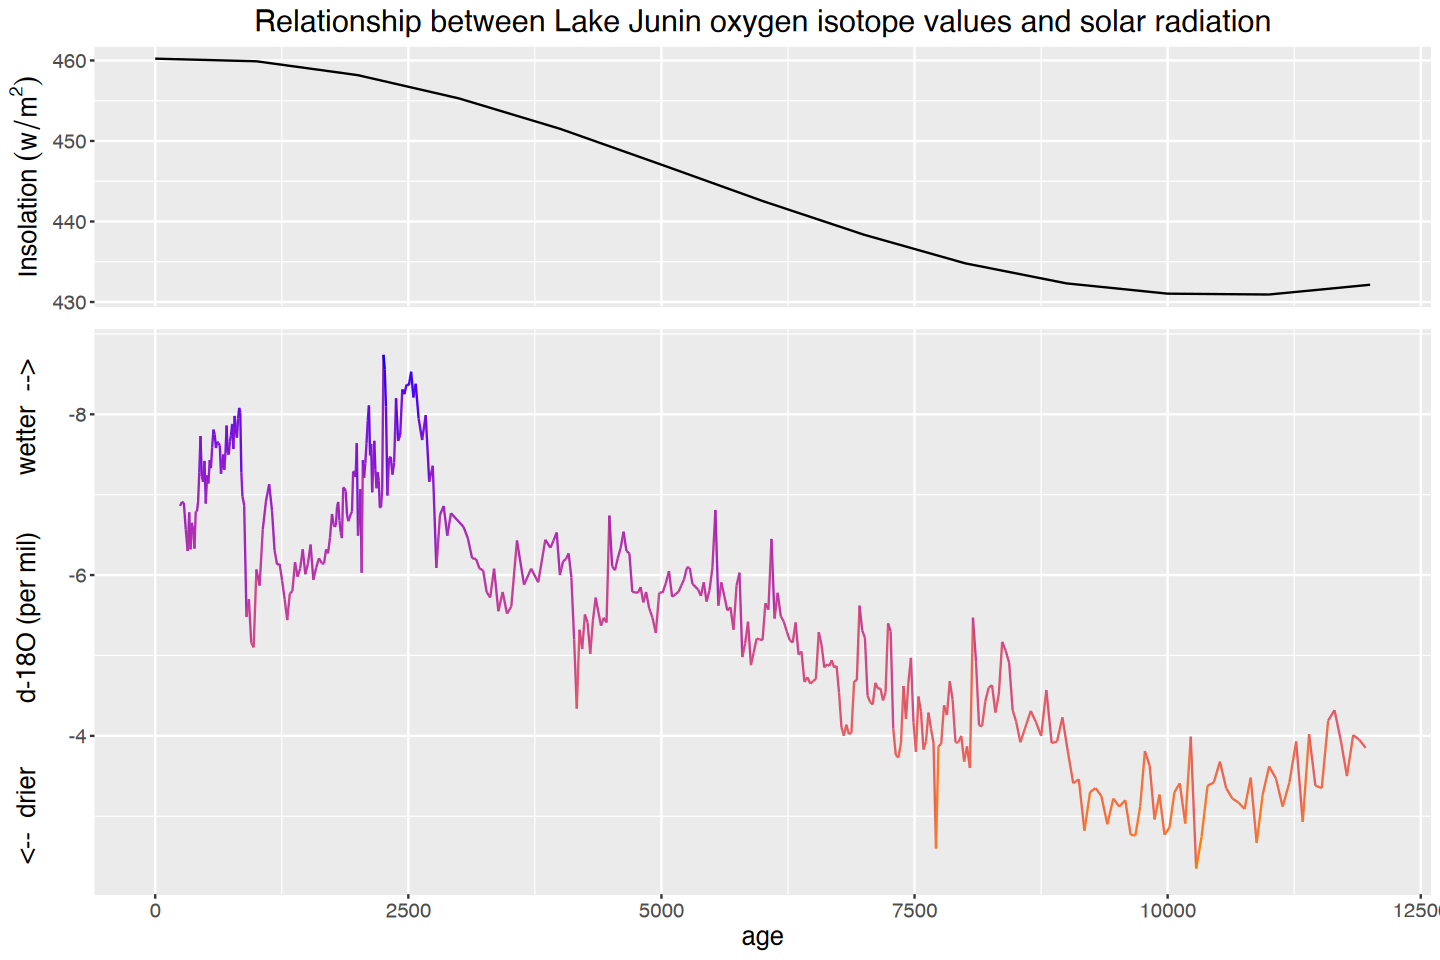

In [243]:
# Subset the data to include only the last 12,000 years
isotopes_holocene <- isotopes |> filter(age <= 12001)
insolation_holocene <- insolation |> filter(age <= 12001)

insolation_plot <- ggplot(
  data = insolation_holocene,
  mapping = aes(x = age, y = insol.11S.DJF)) +
  geom_line() +
  xlim(0, 12000) +
  ggtitle("Relationship between Lake Junin oxygen isotope values and solar radiation") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        plot.title = element_text(hjust = 0.5),
        text=element_text(size=15)) +
  labs(y=bquote('Insolation '(w/m^2)))

d18O_plot <- ggplot(
  data = isotopes_holocene,
  mapping = aes(x = age, y = d18O, color = d18O)) +
  geom_line() +
  scale_y_reverse() +
  scale_colour_gradient(low = "blue", high = "darkorange1") +
  xlim(0, 12000) +
  labs(y='<--  drier         d-18O (per mil)        wetter  -->') +
  theme(legend.position="none",
        text=element_text(size=15))

ggarrange(insolation_plot, d18O_plot, heights = c(1, 2),
          ncol = 1, nrow = 2, align = "v")

Above, we observe a trend of increasing rainfall from the early Holocene to the late Holocene (e.g. a trend towards more negative δ<sup>18</sup>O values). This corresponds with a gradual increase in summer insolation over that period, suggesting a long-term strengthening of the South American summer monsoon. 

<u><b>Isotopic covariance</b></u>
<br>
To further explore how these changes in monsoon strength impacted Lake Junín, we can look at the covariance between oxygen and carbon isotopes. A stronger correlation between O and C isotopes suggests a "closed basin" lake with a lower water level - essentially, the isotopes both become more concentrated due to evaporation. A weaker correlation suggests "open basin" or overflowing (wetter) conditions. 

We can hypothesize that during the early Holocene, a weaker monsoon resulted in reduced rainfall and a lower lake level (closed basin conditions) - this should be reflected in a stronger correlation between O and C values. Vice versa towards the late Holocene, when we'd expect wetter conditions (open basin) leading to a higher lake level, resulting in a weaker correlation between O and C values. 

In [246]:
# Assign intervals for time periods - early/late, and early/middle/late
isotopes_holocene <- isotopes_holocene |> 
  mutate(interval_2div = case_when(age >= 6000 ~ "early",
                              age < 6000 ~ "late")) |> 
  mutate(interval_2div = factor(interval_2div, levels = c("early", "late"))) |>
  mutate(interval_3div = case_when(age >= 8000 ~ "early",
                                   age >= 4000 & age < 8000 ~ "middle",
                                   age < 4000 ~ "late")) |> 
  mutate(interval_3div = factor(interval_3div, levels = c("early", "middle", "late")))

`geom_smooth()` using formula = 'y ~ x'


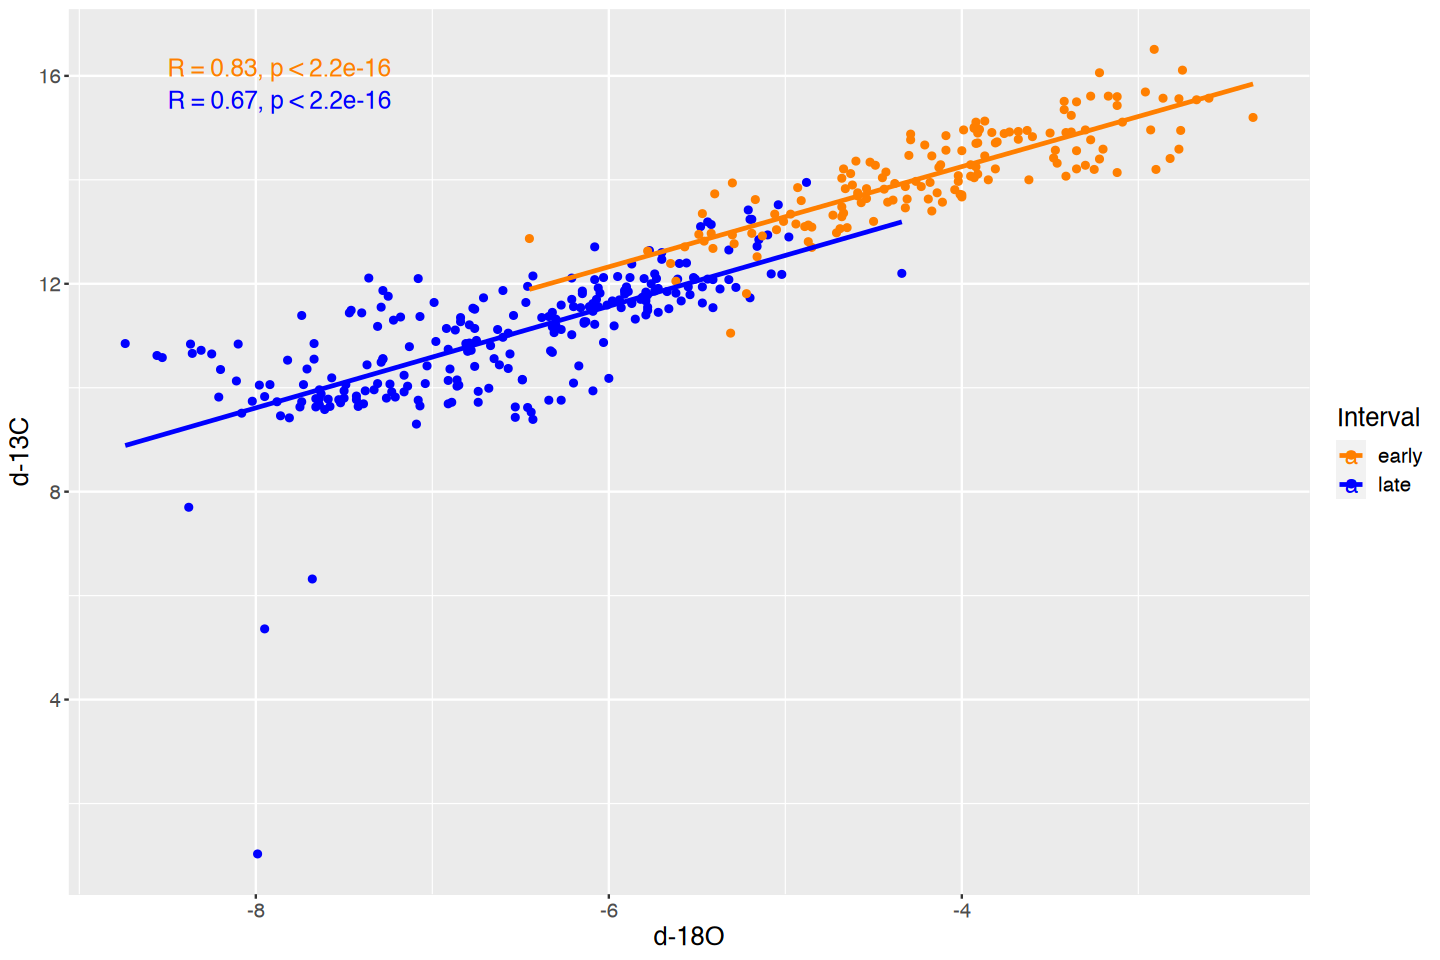

In [247]:
# Scatter plot with correlations for early/late Holocene
isotopes_holocene |> ggplot(
  mapping = aes(x = d18O, y = d13C, color = interval_2div)) +
  geom_point() +
  geom_smooth(method = 'lm', se=F) +
  stat_cor(aes(color = interval_2div), label.x = -8.5, size = 5) +
  scale_colour_manual(name="Interval",
                      values=c("darkorange1", "blue")) +
  theme(text=element_text(size=15)) +
  labs(x='d-18O') +
  labs(y='d-13C')

We do see a subtle change in the relationship over time  - the stronger correlation during the early Holocene (R=0.83) is consistent with drier conditions and lower lake level leading to evaporative enrichment of both isotopes. Wetter and potentially overflowing conditions during the late Holocene produce more scatter (R=0.67), and this is true even after removing the d-13C values that are < 8 (R=0.73, not shown). 

`geom_smooth()` using formula = 'y ~ x'


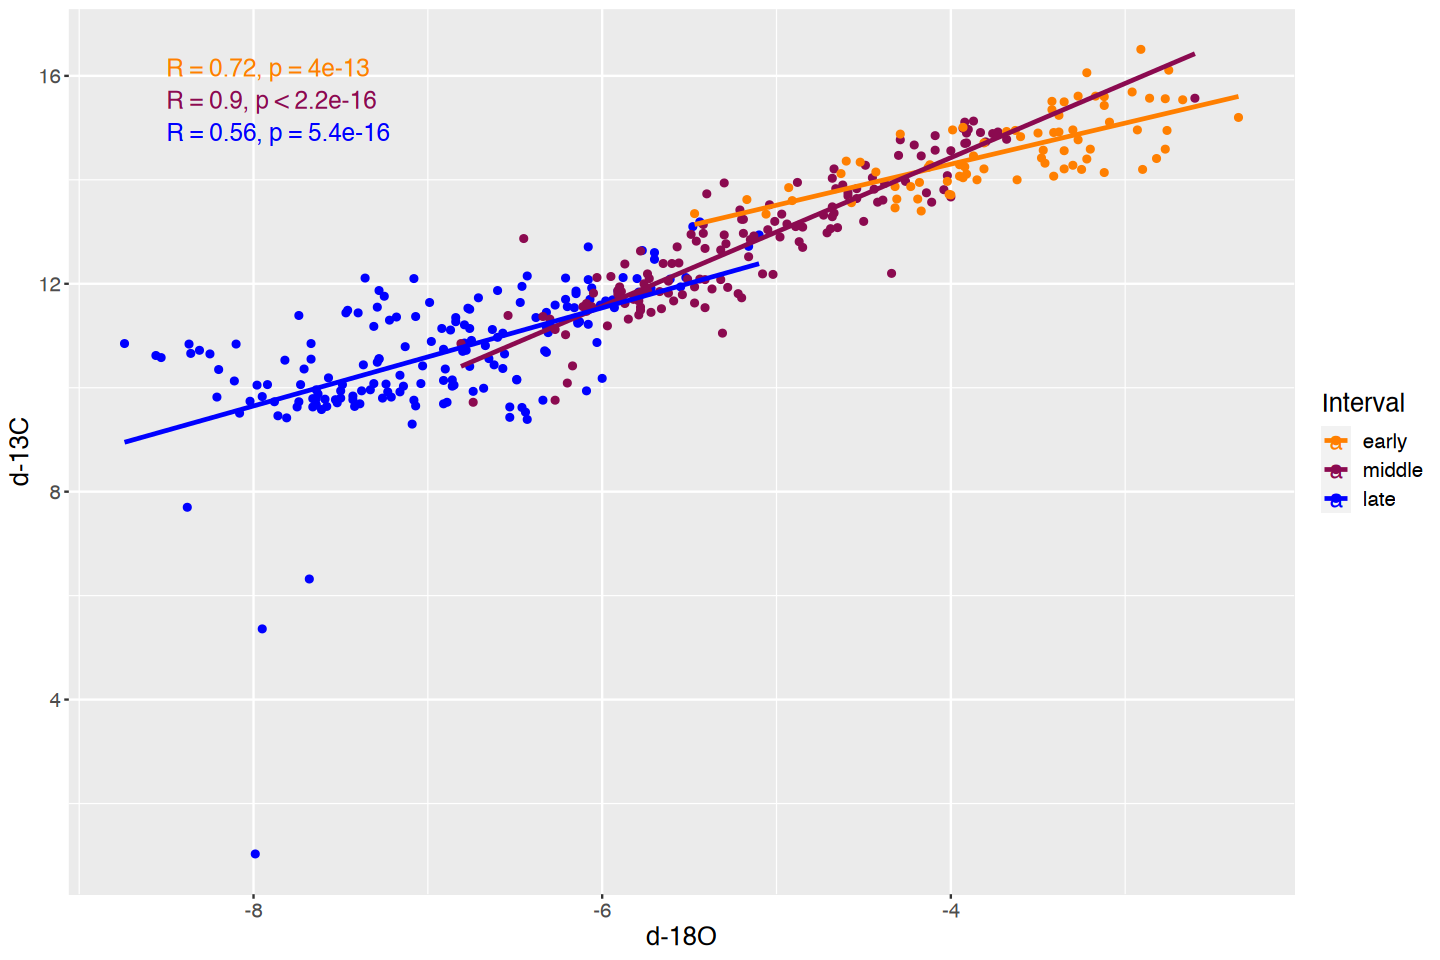

In [187]:
# Scatter plot with correlations for early/middle/late Holocene
isotopes_holocene |> ggplot(
  mapping = aes(x = d18O, y = d13C, color = interval_3div)) +
  geom_point() +
  geom_smooth(method = 'lm', se=F) +
  stat_cor(aes(color = interval_3div), label.x = -8.5, size = 5) +
  scale_colour_manual(name="Interval",
                      values=c("darkorange1", "deeppink4", "blue")) +
  theme(text=element_text(size=15)) +
  labs(x='d-18O') +
  labs(y='d-13C')

Using three subdivisions further emphasizes the weaker correlation during the late Holocene, but also reveals that the mid-Holocene shows the strongest relationship, which is somewhat inconsistent with our hypothesis. It may be that we don't see open basin behavior until a certain lake level threshold, and/or that secondary controls (in addition to insolation) were influencing monsoon strength and lake level during the Holocene. A variety of centennial- to millennial-scale climatic trends potentially affecting tropical South America during this time have been discussed in the paleoclimate literature.

<a name="section_3_2"></a>
## <u>Mineral content during the glacial period</u>

#### Do different proxies for glacial erosion show consistent trends through time? 

At high-elevation sites like Lake Junín (located at 4100 m above sea level in the Andes), increases in rainfall cause tropical mountain glaciers to advance - this leads to erosion of mineral material from the underlying bedrock, which is then washed into the lake. As such, we can measure mineral inputs to the sediment record to study past changes in rainfall amount. This is especially useful since this record does not support oxygen isotope measurements during glacial periods.

There are a variety of proxies for mineral content, such as magnetic susceptibility, gamma radiation, grain size, sediment density, and various elemental concentrations. Here we look at the <b>density</b> of dried bulk sediment and <b>clastic flux</b>, which is a measure of rock fragments derived from quartz particles and clay minerals. Both of these proxies should increase as glacial erosion increases, so they can be used to estimate relative changes in rainfall over long periods of time. 

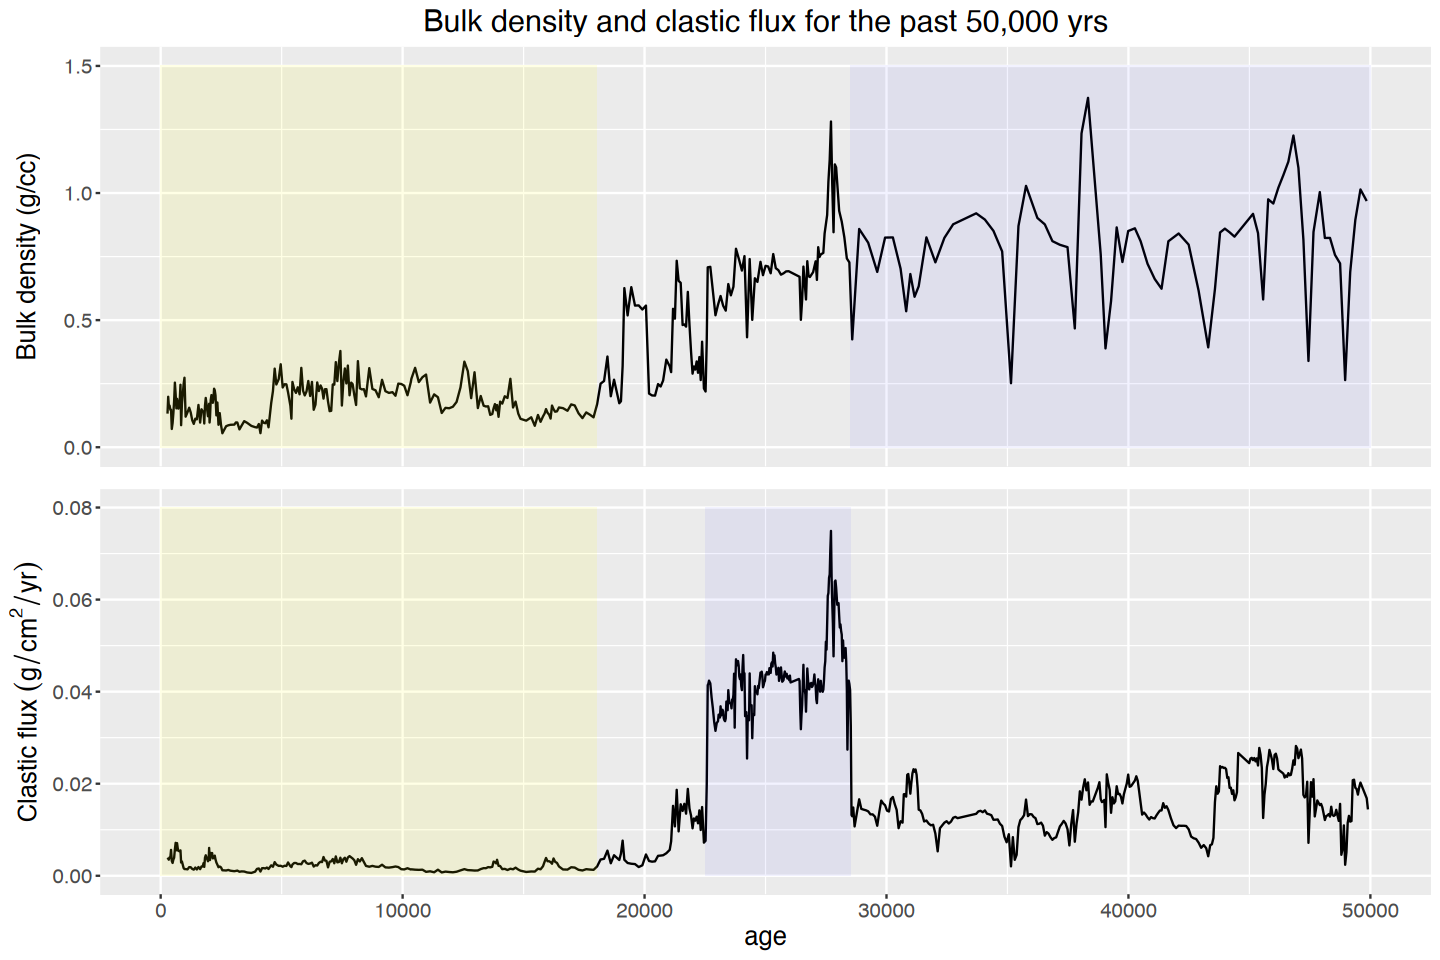

In [327]:
DBD_plot <- ggplot(
  data = density,
  mapping = aes(x = age, y = dry_bulk_density_gcc)) +
  geom_line() +
  xlim(0, 50000) +
  ggtitle("Bulk density and clastic flux for the past 50,000 yrs") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        plot.title = element_text(hjust = 0.5),
        text=element_text(size=15)) +
  labs(y='Bulk density (g/cc)') +
  annotate("rect", xmin = 0, xmax = 18000, ymin = 0, ymax = 1.5, alpha = .1,fill = "yellow") +
  annotate("rect", xmin = 28500, xmax = 50000, ymin = 0, ymax = 1.5, alpha = .05,fill = "blue")


flux_plot <- ggplot(
  data = flux,
  mapping = aes(x = age, y = clastic_flux_gcm2yr)) +
  geom_line() +
  # scale_y_reverse() +
  xlim(0, 50000) +
  theme(text=element_text(size=15)) +
  labs(y=bquote('Clastic flux '(g/cm^2/yr))) +
  annotate("rect", xmin = 0, xmax = 18000, ymin = 0, ymax = 0.08, alpha = .1,fill = "yellow") +
  annotate("rect", xmin = 22500, xmax = 28500, ymin = 0, ymax = 0.08, alpha = .05,fill = "blue")

ggarrange(DBD_plot, flux_plot, heights = c(2, 2),
          ncol = 1, nrow = 2, align = "v")


<b><u>Dissimilar trends</u></b>
<br>
Both proxies show the lowest values during the past ~20 ka (shaded yellow) because the warmer climate did not support large mountain glaciers. Higher values are observed during the cold glacial period, which also displays considerable millennial-scale variability, an important feature of the record that will be addressed later.

A few observations affect our interpretations going forward. First, clastic flux shows a major increase from 22-28 ka, whereas bulk density displays the highest values from 28-50 ka (shaded blue in respective plots). Considering that both proxies are thought to reflect inputs of glacially-eroded material, we might expect more similarity in the overall trend. 

This may be explained by "detrital contamination". The bulk density measurement includes variable amounts of calcium carbonate minerals, which can either be eroded from limestone bedrock like the rest of the mineral matter, or formed within the lake water itself (e.g., not from erosion). Plotting the bulk density data alongside % CaCO<sub>3</sub> (not shown) reveals considerable similarity, suggesting that higher density carbonate minerals are a significant component of bulk density, especially from 28-50 ka.

For this reason, clastic flux may be a more reliable proxy - the calculation removes carbonates and other minerals that form within the lake water, so it's a cleaner estimate of glacial erosion. Furthermore, we do in fact expect to see the greatest inputs of eroded mineral material from ~22-28 ka, which is the coldest part of the last glacial period and characterized by major glacier advances worldwide. 

<b><u>Sample resolution</u></b>
<br>
These proxy measurements were generated individually by lab workers, so they have relatively low sampling resolution. Bulk density measurements are spaced every 4-8 cm during the glacial period, with peaks and troughs often defined by a single data point. Clastic flux, on the other hand, was calculated every 2 cm during that interval, making it somewhat more conclusive.

In contrast to both these proxies, instrument-based techniques such as scanning XRF produce fast, inexpensive data sets every 0.5 cm.  However, interpretation of XRF data is less straightforward - of the 20+ elements measured by the scanner, which one(s) best represent glacial erosion of mineral material? To answer this, we compare select elements to more "well known" or better understood proxies - in this case, the clastic flux data will anchor our interpretations of the higher resolution XRF data set.

Before proceeding, let's explore a logarithmic transformation of the clastic flux data:


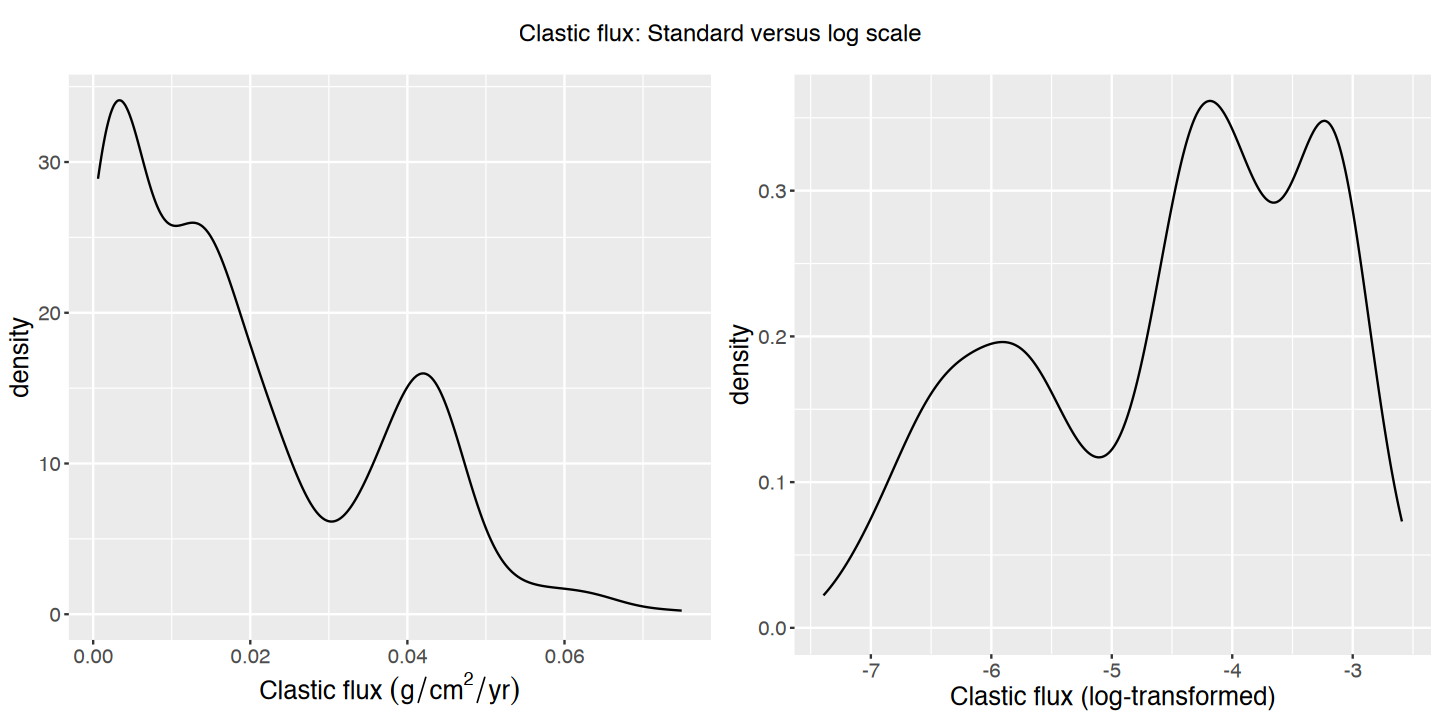

In [329]:
# converting flux to log scale 

flux <- flux |> mutate(flux_log = log(clastic_flux_gcm2yr))
# note: the log is always negative when the numbers are less than 1

# flux density plot
flux_density_plot <- ggplot(
  data = flux,
  mapping = aes(x = clastic_flux_gcm2yr)) +
  geom_density() +
  labs(x=bquote('Clastic flux '(g/cm^2/yr))) +
  theme(text=element_text(size=15))

# flux_log density plot
flux_log_density_plot <- ggplot(
  data = flux,
  mapping = aes(x = flux_log)) +
  geom_density() +
  labs(x = 'Clastic flux (log-transformed)') +
  theme(text=element_text(size=15))

p <- plot_grid(flux_density_plot, flux_log_density_plot, ncol = 2, nrow = 1)
title <- ggdraw() + draw_label("Clastic flux: Standard versus log scale", fontface='bold')

options(repr.plot.width = 12, repr.plot.height = 6)
plot_grid(title, p, ncol = 1, rel_heights=c(0.1, 1)) # rel_heights controls title margin values


<b>Logarithmic transformation of clastic flux</b>

The clastic flux data in its original format (left panel above) is right-skewed - most values are closer to the lower limit, e.g. from 0-0.01 g/cm<sup>2</sup>/yr, which characterize the Holocene. 

Log transformations can be helpful for right-skewed data - taking the log "pulls in" more extreme values on the right (the high values) closer to the median, while values at the far left (low values) tend to get stretched back further away from the median. 

Taking the natural log of the clastic flux data (right panel above) transforms it to left-skewed, emphasizing the values in the higher, glacial end of the range, which is the portion of interest for our analysis. This is a relatively common transformation and is useful for visualizing the millennial-scale fluctuations from 28-50 ka, which become more pronounced:

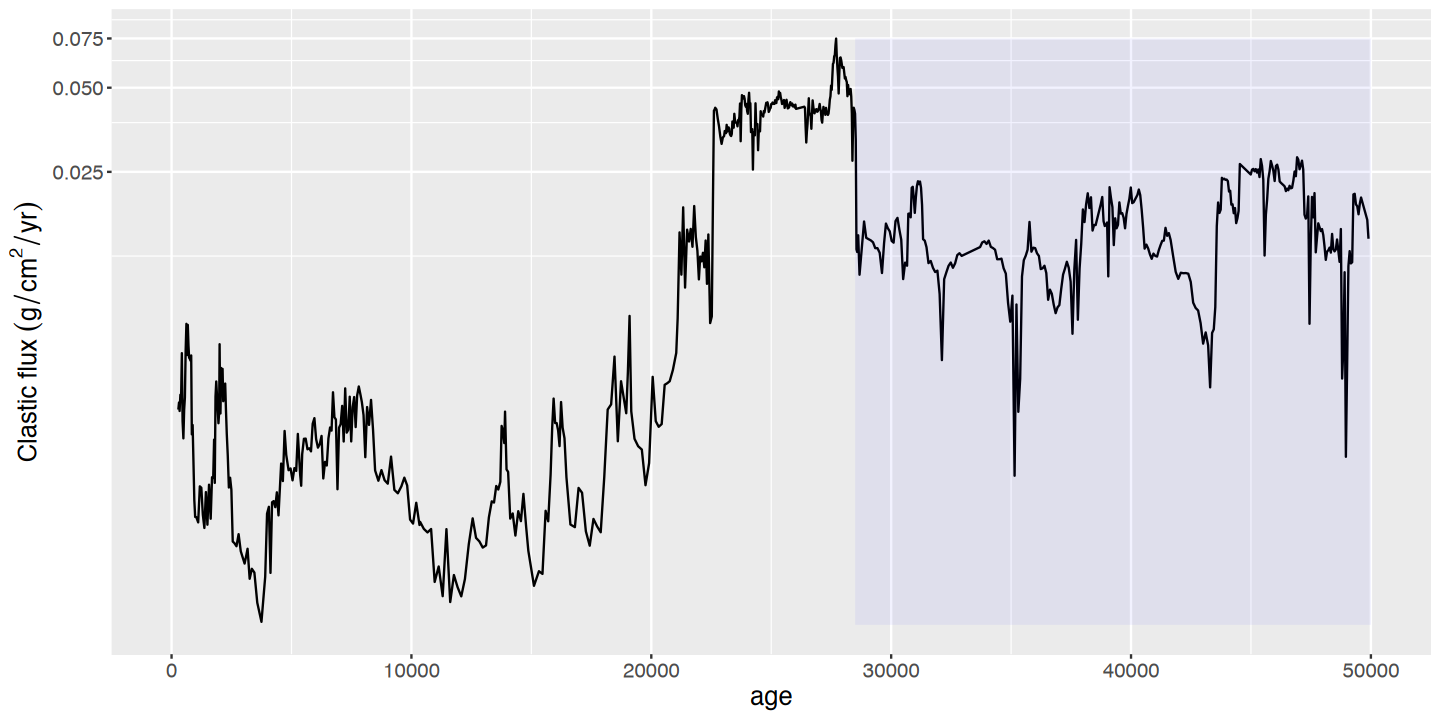

In [297]:
# clastic flux on log scale
options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(
  data = flux,
  mapping = aes(x = age, y = clastic_flux_gcm2yr)) +
  geom_line() +
  coord_trans(y = "log10") +
  xlim(0, 50000) +
  theme(text=element_text(size=15)) +
  labs(y=bquote('Clastic flux '(g/cm^2/yr))) +
  annotate("rect", xmin = 28500, xmax = 50000, ymin = 0.0006, ymax = 0.075, alpha = .05,fill = "blue") 


<a name="section_3_3"></a>
## <u>Elemental inputs during the glacial period</u>

#### Which element(s) from the XRF data set are most useful as a climate indicator?

As mentioned, XRF scanning provides high-resolution and non-destructive elemental analysis of sediment cores. Results are presented in counts per second and are semi-quantitative unless calibrated with reference materials.

Here we'll use the log-transformed clastic flux data as a reference point to determine which element(s) provide the best record of glacially-eroded mineral matter, and can therefore serve as a high-resolution proxy for changes in rainfall during the last glacial period. 

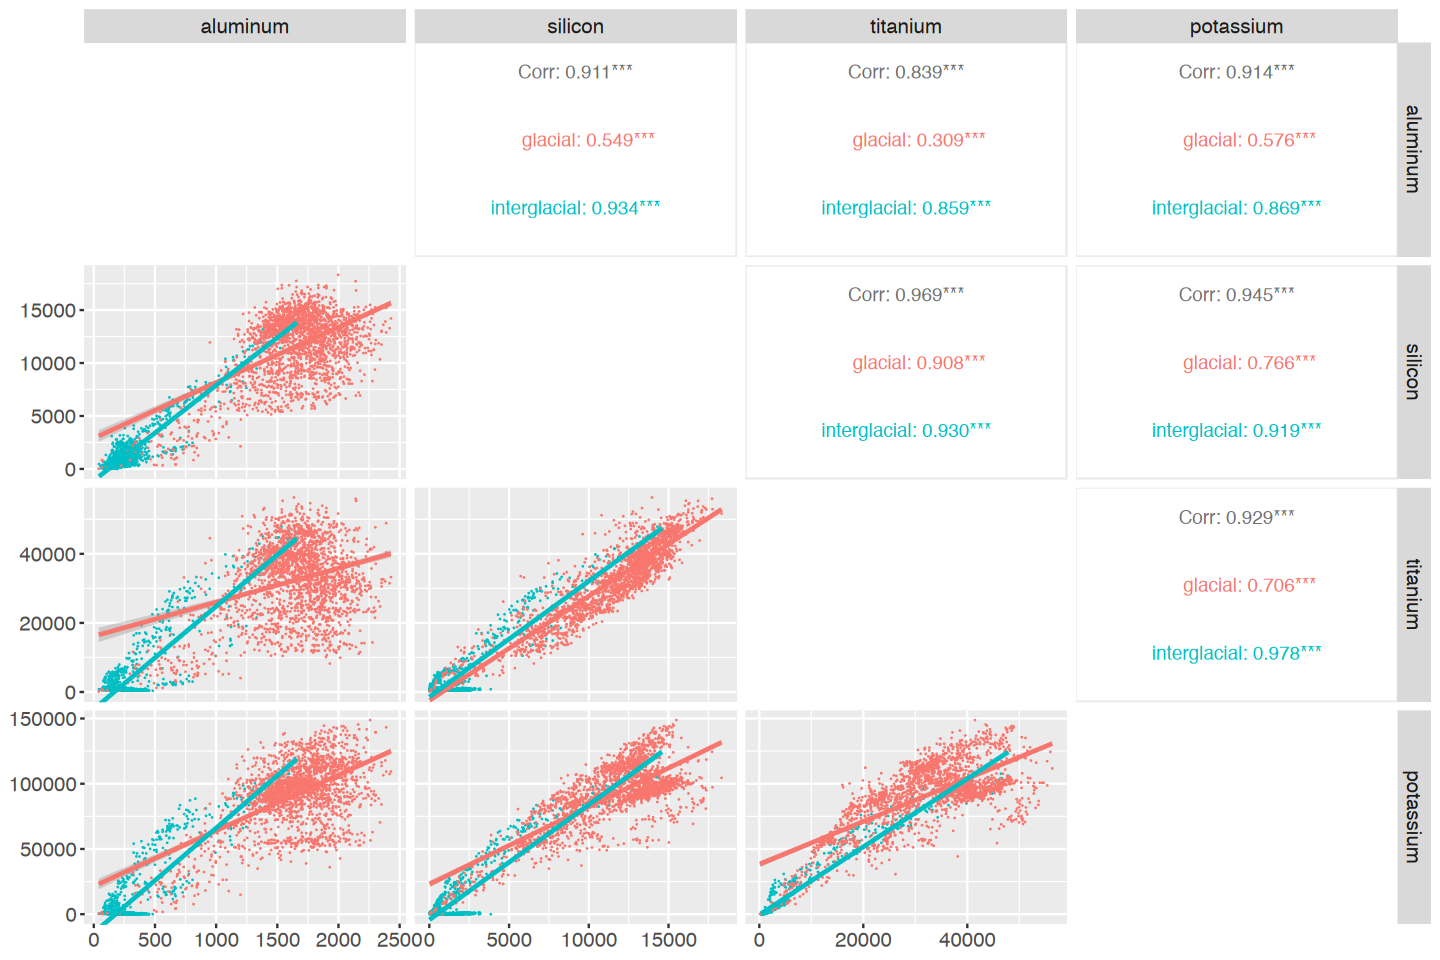

In [276]:
# add factors to the xrf data frame to specify glacial vs interglacial intervals
xrf <- xrf |>
  mutate(interval = case_when(depth_m <= 6.665 ~ "interglacial",
                              depth_m > 6.665 ~ "glacial")) |>
  mutate(interval = factor(interval))

options(repr.plot.width = 12, repr.plot.height = 8)

# Facet scatter plots of select elements
ggpairs(xrf, columns = 7:10, 
        mapping = aes(color = interval, stroke = NA),
        lower = list(continuous = wrap("smooth", size=0.5)),
        diag = list(continuous = "blankDiag")) +
  theme(text=element_text(size=15))

<u><b>Initial interpretations</b></u>

These four elements were chosen because they should be abundant in the silicate minerals of the Andes, and stable once eroded.

The scatter plots give the Pearson correlation coefficient for each pair. During the glacial period, silicon and titanium show the strongest relationship with each other (r=0.908), suggesting they are derived from rocks that are widespread in the area and are affected to a similar degree by the same processes (erosion, rainfall).  Aluminum is poorly correlated with the other elements during the glacial period and has the lowest concentration, making it a less reliable indicator of changes in climatic conditions. 

<b>How do these elements compare with the clastic flux data?</b> 

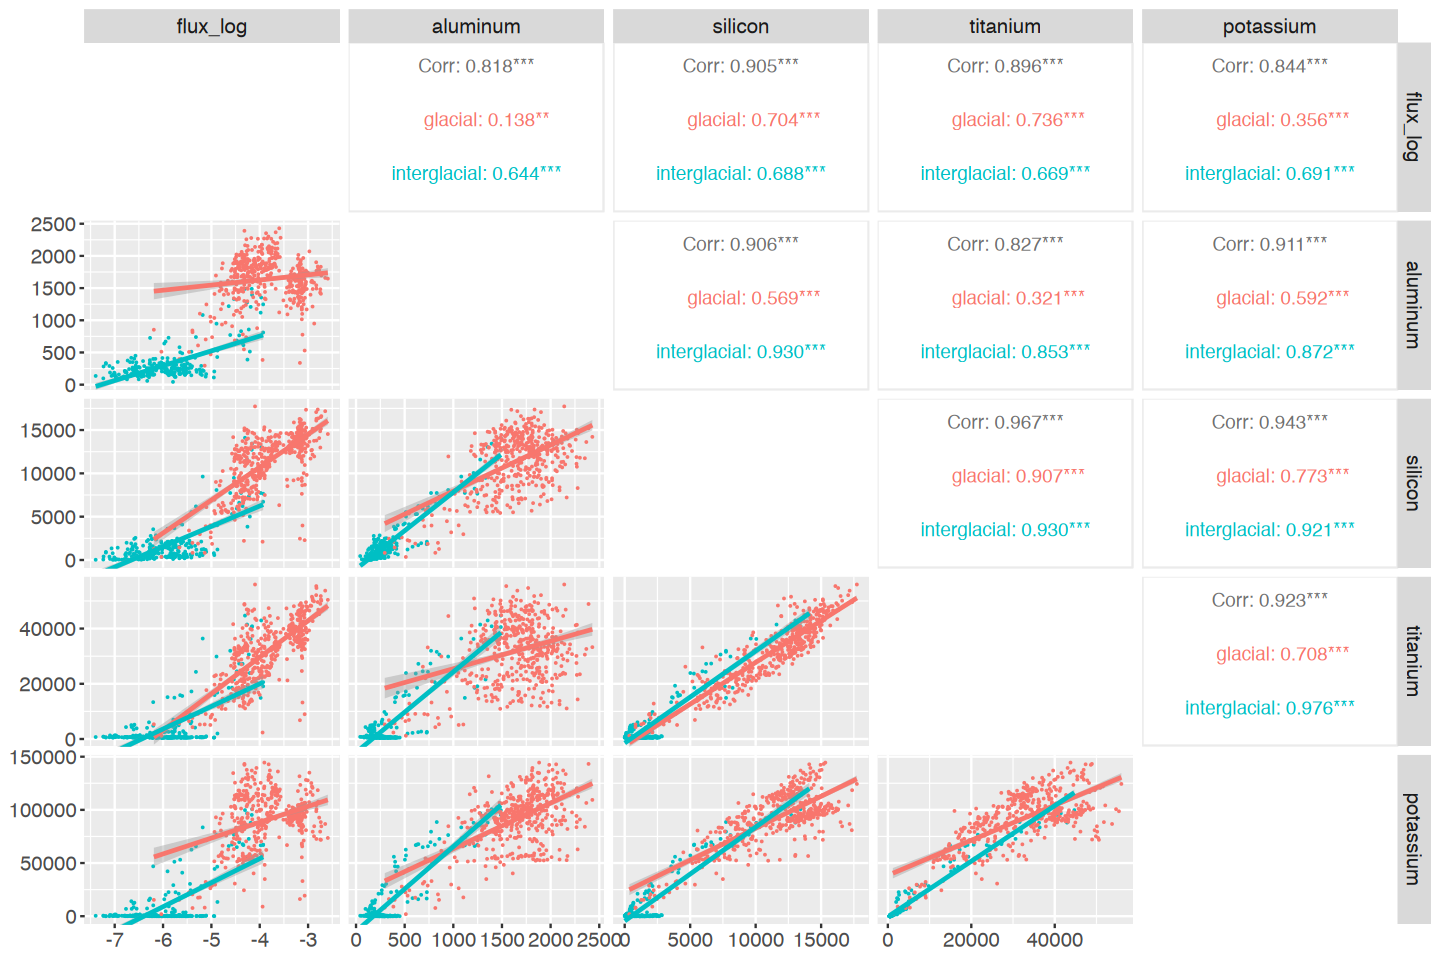

In [278]:
# Scatter plot matrix - clastic flux vs XRF

flux_xrf <- flux |> left_join(xrf, join_by(depth_m)) |> drop_na()

ggpairs(flux_xrf, columns = c(4,10:13),
        mapping = aes(color = interval, stroke = NA),
        # lower = list(continuous = "smooth"),
        lower = list(continuous = wrap("smooth", size=0.8)),
        diag = list(continuous = "blankDiag")) +
  theme(text=element_text(size=15))


Note the top row and left column which summarize clastic flux compared with the four elements. Titanium shows the best correlation during the glacial period, and silicon is a close second. Potassium is rather weak and aluminum is the weakest.

However, the correlations drawn here are based on a subset of data points that share the same sampling depths. Since the XRF data is 5x higher resolution than the clastic flux data, and each XRF measurement summarizes a smaller slice of sediment, we cannot be sure these rows reflect identical sediment intervals. 

The results may be improved by taking <b>moving window averages</b> of the XRF data, so that each data point used in the correlation integrates a larger span of sediment. This will also help smooth out some of the scatter that is inherent in high resolution data sets. 

In [110]:
# Moving window average functions: n is window size; s=1 (for backward only) or 2 (centered window)
ma3 <- function( x, n=3, s=2 ){ as.numeric( stats::filter( x, rep( 1/n, n ), sides=2 ) ) } 
ma5 <- function( x, n=5, s=2 ){ as.numeric( stats::filter( x, rep( 1/n, n ), sides=2 ) ) } 

# Create data frames with moving averages of 3 and 5 applied to XRF data
my_cols <- c('aluminum', 'silicon', 'titanium', 'potassium')
xrf_ma3 <- xrf |> mutate(across(my_cols, function(x)ma3(x)))
xrf_ma5 <- xrf |> mutate(across(my_cols, function(x)ma5(x)))
    
# Join each data frame to clastic flux data and drop NAs from first couple rows
flux_xrf_ma3 <- flux |> left_join(xrf_ma3, join_by(depth_m)) |> drop_na()
flux_xrf_ma5 <- flux |> left_join(xrf_ma5, join_by(depth_m)) |> drop_na()

# Get correlation coefficients for different moving averages during the glacial interval
flux_xrf_corrs_glacial <- 
  flux_xrf |> select(4, 10:14) |> group_by(interval) |> correlation() |> as.data.frame() |> select(4) |> slice(1:4)

flux_xrf_ma3_corrs_glacial <- 
  flux_xrf_ma3 |> select(4, 10:14) |> group_by(interval) |> correlation() |> as.data.frame() |> select(4) |> slice(1:4)

flux_xrf_ma5_corrs_glacial <- 
  flux_xrf_ma5 |> select(4, 10:14) |> group_by(interval) |> correlation() |> as.data.frame() |> select(4) |> slice(1:4)
    
# Put into a data frame
corrs_flux_xrf_glacial <- data.frame(my_cols,
                                     flux_xrf_corrs_glacial,
                                     flux_xrf_ma3_corrs_glacial,
                                     flux_xrf_ma5_corrs_glacial)

colnames(corrs_flux_xrf_glacial) <- c('Element', 'No Moving Average', '3-pt Moving Average', '5-pt Moving Average') 

In [112]:
# Table with strongest and weakest correlations
df_name <- corrs_flux_xrf_glacial |> mutate(across(everything(), as.character))

table_corrs_glacial <- 
  datatable(df_name, 
            caption = htmltools::tags$caption(style = 'caption-side: top; text-align: left; color: black;  font-size: 150%;',
                                              'Correlation coefficients for clastic flux vs key elements during the glacial period'),
            options = list(dom = 't'))

invisible(
sapply(c(1:ncol(df_name)),function(x){
  table_corrs_glacial <<- table_corrs_glacial |>  formatStyle(colnames(df_name)[[x]],backgroundColor = styleEqual(max(df_name[[x]]), 'palegreen'))
})) # using invisible() to suppress unnecessary output

invisible(
sapply(c(1:ncol(df_name)),function(x){
  table_corrs_glacial <<- table_corrs_glacial |>  formatStyle(colnames(df_name)[[x]],backgroundColor = styleEqual(min(df_name[[x]]), 'tomato'))
}))

table_corrs_glacial <<- table_corrs_glacial |>  formatStyle(colnames(df_name)[[1]],backgroundColor = styleEqual((df_name[[1]]), 'white'));

table_corrs_glacial

HTML widgets cannot be represented in plain text (need html)

<u><b>Conclusions</b></u>

The summary above confirms that titanium consistently has the strongest correlation with clastic flux, making it the most suitable element to use as a high-resolution proxy for glacial erosion and rainfall. The moving window averages only marginally improved the correlations for all elements, suggesting there's not a large degree of variability at sub-centimeter scales and that the original, unsmoothed XRF data can be used in future analyses.

<a name="section_4"></a>
# 4. Visualization and interpretation

<u><b>Climate change during the last glacial period</b></u>

The last glacial period has been extensively studied because of a series of dramatic and abrupt temperature shifts first observed in Greenland ice cores, known as Dansgaard-Oeschger (D-O) events. These events have since been recorded in a variety of other climate records, and their fingerprint varies by region and context - in the tropics, they often manifest as changes in monsoon strength and therefore rainfall patterns.

The Lake Junín sediment record provides a glimpse into how these abrupt events impacted the climate and environment of the Andes. Below are some key figures that summarize our findings and highlight the climate teleconnections between the tropics and polar regions.


<u>Note:</u> 
These figures were generated using Base R rather than ggplot because it offers more flexibility for arranging multiple visual features within a single panel, dual y-axes, and other customizations needed in publication-quality figures. The code is lengthy and not included here. The original figures can be found at: https://www.nature.com/articles/s41467-020-19000-8

<u><b>Major features of the sediment record</b></u>

The age-depth model for Lake Junín (panel f below) consists of 79 radiocarbon ages and is precise enough to draw conclusions about rapid climate fluctuations during the past 50 ka. The most prominent pattern revealed in the sediment record is the series of dark, organic-rich layers observed throughout the last glacial period (highlighted by the light grey vertical lines and high values of TOC, panel d). These are interpreted to be peat layers formed during lake lowstands, e.g. times when the water level dropped and the surrounding carbon-rich peatlands encroached towards the center of the lake. These intervals are further characterized by lower levels of mineral inputs (panels a-c, e), suggesting that frequent episodes of drought were accompanied by glacial retreat and subsequent reductions in erosion. 


<!-- original; works in chrome but not github -->
<!-- <center><img src='Fig-2-with-caption.png' width='700'></center> -->

<!-- doesnt work in chrome or github -->
<!-- <center><img src='attachment:Fig-2-with-caption.png' width='700'></center> -->


<!-- doesn't work in chrome; doesn't work in github -->
<!-- <img src='attachment:Fig-2-with-caption.png' width='700'> -->


works in chrome but its large- no size control;
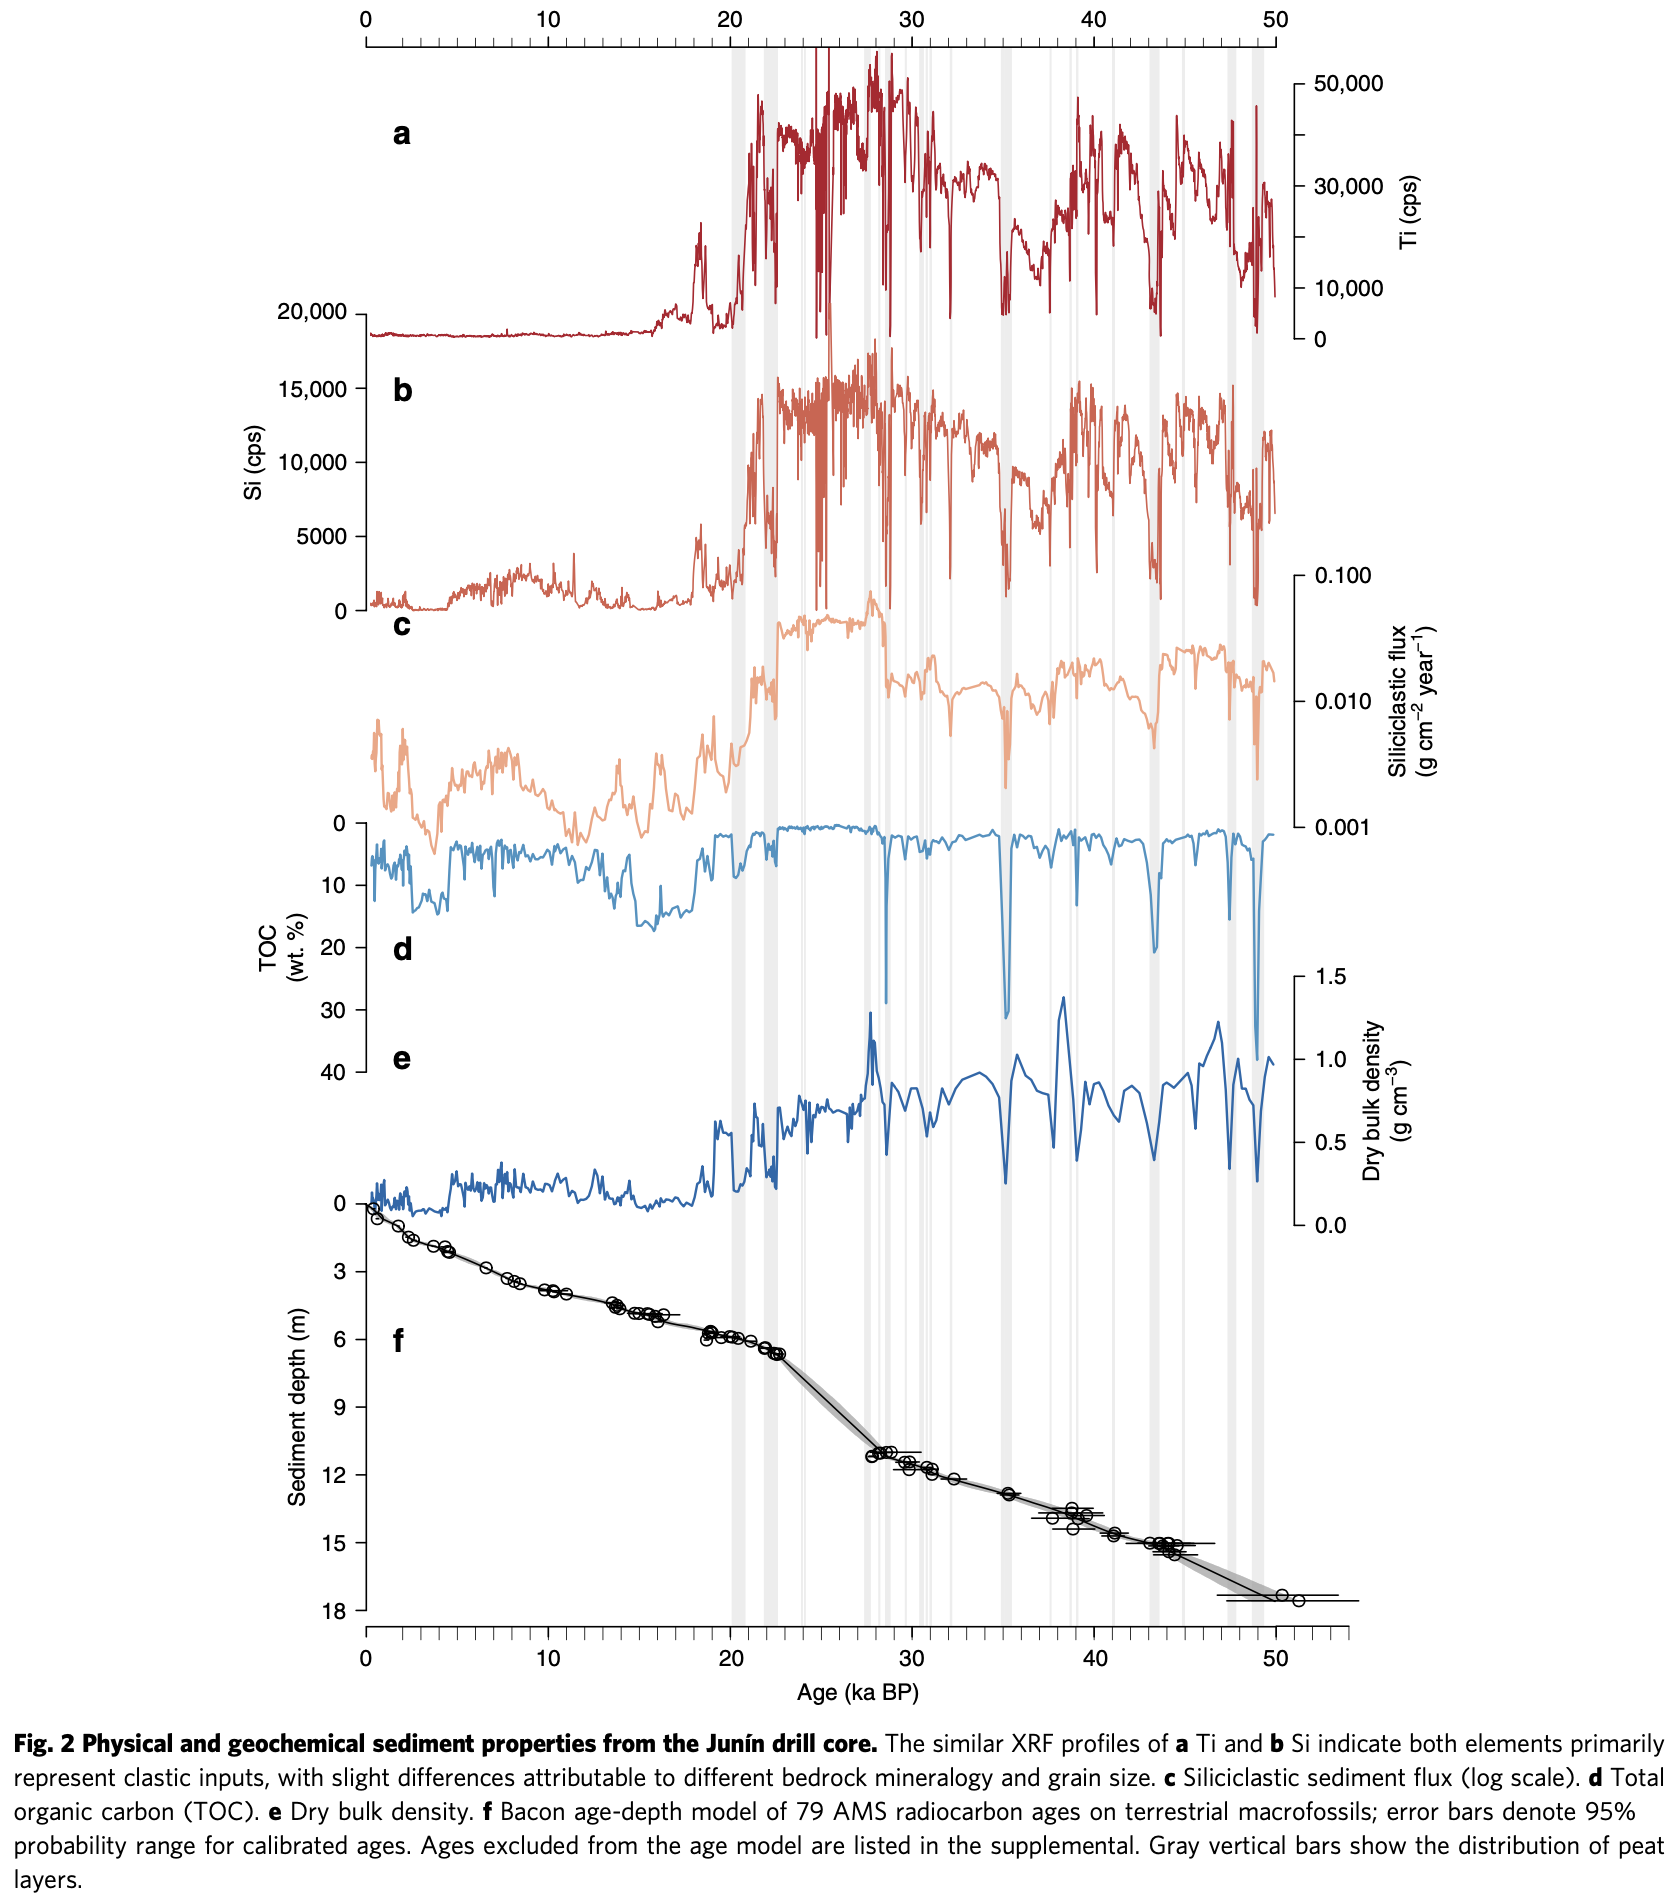

<u><b>Abrupt climate events</b></u>

Below is the Junín titanium record (a) with two other high resolution records that record a remarkably similar overall pattern during the last 50 ka - a cave deposit ~25 km from Lake Junín that measures rainfall amount (b) and the Greenland ice core record which measures air temperature (c). Estimated error envelopes are shown in blue for Junín and Greenland (not available for the cave record). 

The grey vertical lines denote D-O events 2-13. A total of 25 of these events were identified and numbered based on the Greenland record during the last glacial period, and each constitutes an abrupt warming of several degrees followed by a gradual return to colder temperatures. During most of these abrupt warmings, we observe a similarly rapid shift toward drier conditions in the two Andean records, wherein the timing is consistent on centennial scales and/or within error estimates. 

This is a significant finding considering the great distance between Greenland and the tropical Andes, and the fact that it's recorded in multiple different proxies reflecting unique geologic conditions and modes of preservation. Such similarity points to a strong and persistent relationship between Arctic temperatures and tropical monsoon strength.

<center><img src='Fig-supplemental-annotated.png' width='600'></center>

<u><b>Teleconnections in the global climate system</b></u>

To further highlight the global nature of D-O events, several additional records derived from both the marine and terrestrial realms are plotted below, showing broad similarity from a variety of geologic archives.

The key to understanding the mechanism that links high-latitude temperature to tropical monsoon strength likely lies in the system of ocean currents that distribute energy and heat around the planet. The Atlantic Meridional Overturning Circulation (AMOC, also known as the thermohaline circulation) functions as an underwater conveyor belt that distributes heat from surface waters in the warm tropical Atlantic towards high northern latitudes, contributing to the mild climate of most of Europe. In turn, frigid Arctic waters are transported in the deep ocean back to the tropics.  

Consider two scenarios. When large amounts of freshwater are released from ice bergs and sea ice in the North Atlantic, the density of the surface ocean is reduced and the ocean conveyor system slows down. This means less heat is transported northward, and it instead pools in the tropics - this heat invigorates the South American summer monsoon and leads to increased rainfall in the region of Lake Junín. 

On the other hand, warm phases are linked to a more vigorous AMOC, which transports more heat and energy northward, away from the tropics, leading to a weaker South American summer monsoon and reduced rainfall. This scenario could explain the climate configuration during D-O events, when the level of Lake Junín dropped, peat layers formed, and mountain glaciers retreated. 

Tracking past changes in the strength of AMOC is less straightforward and has been attempted by a limited number of studies - one such example is shown below (f) based on the elemental ratio of seawater, and broadly supports the mechanism described. While questions remain about the precise timing and cause/effect relationship of these events, the planetary-wide impact of rapid temperature change is clear and these geologic records emphasize the sensitivity of the climate system to abrupt tipping points.

<center><img src='Fig-3-with-caption.png' width='700'></center>

<u><b>What does this mean for current and future climate change?</b></u>

Climate models rely on paleoclimate studies to explore and test the full range of possible climate change scenarios. So do these past responses to rapid warming serve as analogs for future change? It's complicated - the D-O events documented here were a persistent feature of the last glacial period, not the interglacial period we are currently in. Yet there are parallels with current climate change - the Arctic is warming rapidly, resulting in loss of ice sheets and sea ice. A warmer Arctic could draw the tropical rainbelt further north<sup>1,2</sup> as it likely did in the past. At the same time, some studies suggest a possible slowdown of AMOC in the future<sup>3,4</sup>, which could potentially push the rainbelt southward. There are ongoing efforts to resolve these complex features of the modern climate system and to better predict the impacts for tropical regions. 

Such work is critical, as changes in atmospheric and oceanic circulation will be superimposed on temperature changes. Meltwater from mountain glaciers serves as an important buffer to seasonal changes in rainfall throughout the tropics, and the ongoing loss of these glaciers worldwide due to global warming poses major threats to water resources for ecosystems and millions of people. Importantly, the sediment record from Lake Junín further demonstrates the sensitivity of this region to changes in monsoon strength, and the possibility for extended periods of lower lake level and drought.

<br>

References:
1. Lee, J.-Y. & Wang, B. Future change of global monsoon in the CMIP5. Clim.
Dyn. 42, 101–119 (2014).
2. Broecker, W. S. & Putnam, A. E. Hydrologic impacts of past shifts of Earth’s
thermal equator offer insight into those to be produced by fossil fuel CO2.
Proc. Natl Acad. Sci. USA 110, 16710–16715 (2013).
3. Gregory, J. M. et al. A model intercomparison of changes in the Atlantic
thermohaline circulation in response to increasing atmospheric CO2
concentration. Geophys. Res. Lett. 32, L12703 (2005).
4. Rahmstorf, S. et al. Exceptional twentieth-century slowdown in Atlantic Ocean overturning circulation. Nat. Clim. Change. 5, 475-480 (2015).

<center><img src='lake_pic.png' width='900'></center>